In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [5]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


Generando 10 recetas aleatorias, esto puede tardar varios minutos...


<AxesSubplot:>

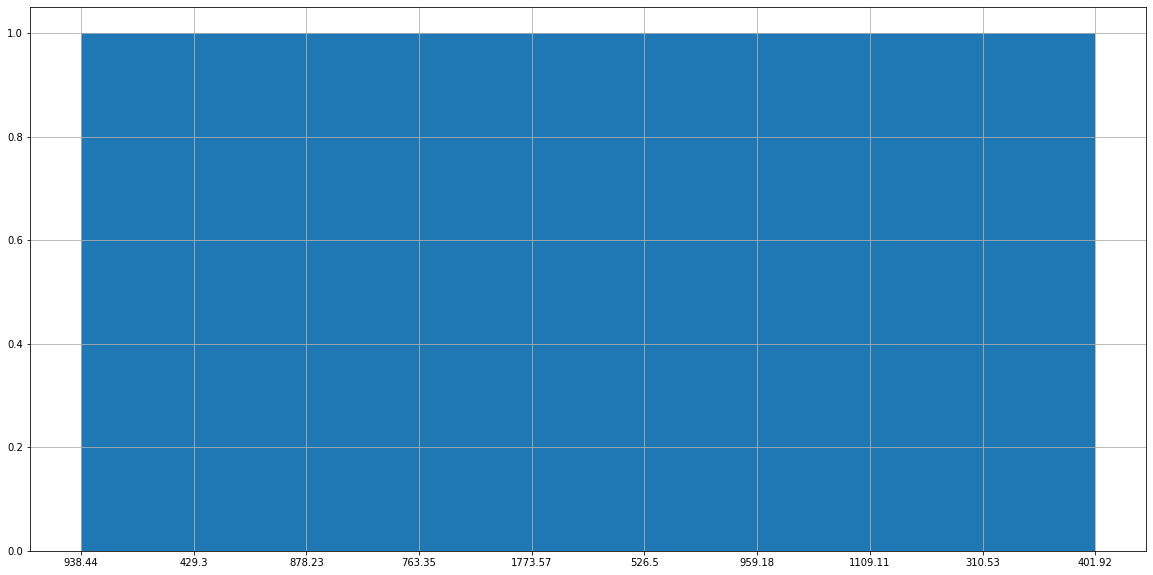

In [6]:
test = recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=10,
                                                  min_kcal=300, max_kcal= 1800,
                                                  numero_recetas=10, _INTENTOS=5,
                                                  )

df = pd.DataFrame(test, columns=['ingredientes', 'kcal', 'carbs', 'prot', 'grasas']) 
plt.figure(figsize=(20,10))
df['kcal'].hist()

* Entrenar información nutricional


ITERACIÓN: 1
VAL_MAE: 1000
min unidades: 1  max unidades: 10
min kcal: 300  max kcal: 800
Entrenando desde epoch 0
------------------------------------------

Generando 500 recetas aleatorias, esto puede tardar varios minutos...
Calculando vector de características de 500 recetas...


100%|██████████| 500/500 [01:51<00:00,  4.49it/s]


Epoch 1/15
13/13 [==============================] - 3s 144ms/step - loss: 121.8047 - mae: 121.8047 - val_loss: 118.3016 - val_mae: 118.3016
Epoch 2/15
13/13 [==============================] - 2s 147ms/step - loss: 121.0669 - mae: 121.0669 - val_loss: 117.9975 - val_mae: 117.9975
Epoch 3/15
13/13 [==============================] - 3s 204ms/step - loss: 120.4779 - mae: 120.4779 - val_loss: 117.6948 - val_mae: 117.6948
Epoch 4/15
13/13 [==============================] - 2s 173ms/step - loss: 121.9883 - mae: 121.9883 - val_loss: 117.3955 - val_mae: 117.3955
Epoch 5/15
13/13 [==============================] - 2s 166ms/step - loss: 120.3631 - mae: 120.3631 - val_loss: 117.0958 - val_mae: 117.0958
Epoch 6/15
13/13 [==============================] - 2s 169ms/step - loss: 120.3396 - mae: 120.3396 - val_loss: 116.7992 - val_mae: 116.7992
Epoch 7/15
13/13 [==============================] - 2s 164ms/step - loss: 120.0629 - mae: 120.0629 - val_loss: 116.5008 - val_mae: 116.5008
Epoch 8/15
13/13 [==

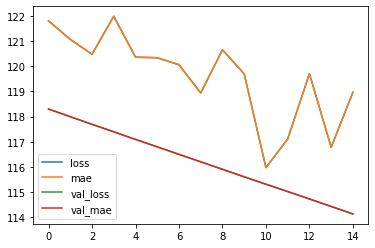

1/1 [==============================] - 0s 481ms/step - loss: 124.7160 - mae: 124.7160
[124.7160415649414, 124.7160415649414]
1/1 [==============================] - 0s 426ms/step
receta 0 kcal_true: 713.5 kcal_pred: 912.1252  precisión: 78.2 %
receta 0 carbohydrate_true: 64.4 carbohydrate_pred: 126.56444  precisión: 50.9 %
receta 0 protein_true: 1.53 protein_pred: 29.844498  precisión: 5.1 %
receta 0 total_fat_true: 52.06 total_fat_pred: 15.334041  precisión: 29.5 %
---------------------------------------------------------------------------
receta 1 kcal_true: 587.5 kcal_pred: 915.9861  precisión: 64.1 %
receta 1 carbohydrate_true: 97.6 carbohydrate_pred: 58.111286  precisión: 59.5 %
receta 1 protein_true: 21.44 protein_pred: 50.40322  precisión: 42.5 %
receta 1 total_fat_true: 20.48 total_fat_pred: 31.12697  precisión: 65.8 %
---------------------------------------------------------------------------
receta 2 kcal_true: 549.0 kcal_pred: 758.58295  precisión: 72.4 %
receta 2 carbohydrat

100%|██████████| 500/500 [01:44<00:00,  4.77it/s]


Epoch 15/29
13/13 [==============================] - 8s 539ms/step - loss: 58.7702 - mae: 58.7702 - val_loss: 59.1035 - val_mae: 59.1035
Epoch 16/29
13/13 [==============================] - 7s 548ms/step - loss: 58.6840 - mae: 58.6840 - val_loss: 59.0926 - val_mae: 59.0926
Epoch 17/29
13/13 [==============================] - 7s 544ms/step - loss: 58.7981 - mae: 58.7981 - val_loss: 59.0930 - val_mae: 59.0930
Epoch 18/29
13/13 [==============================] - 7s 542ms/step - loss: 60.9681 - mae: 60.9681 - val_loss: 59.1023 - val_mae: 59.1023
Epoch 19/29
13/13 [==============================] - 7s 549ms/step - loss: 60.5480 - mae: 60.5480 - val_loss: 59.0768 - val_mae: 59.0768
Epoch 20/29
13/13 [==============================] - 8s 604ms/step - loss: 61.0048 - mae: 61.0048 - val_loss: 59.0512 - val_mae: 59.0512
Epoch 21/29
13/13 [==============================] - 8s 616ms/step - loss: 59.8453 - mae: 59.8453 - val_loss: 59.0319 - val_mae: 59.0319
Epoch 22/29
13/13 [======================

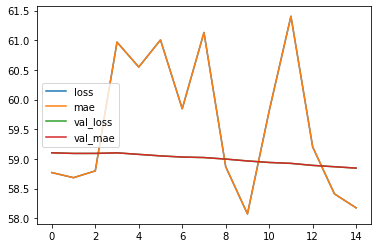

1/1 [==============================] - 0s 277ms/step - loss: 45.9945 - mae: 45.9945
[45.994529724121094, 45.994529724121094]
1/1 [==============================] - 0s 202ms/step
receta 0 kcal_true: 813.5 kcal_pred: 880.0807  precisión: 92.4 %
receta 0 carbohydrate_true: 42.22 carbohydrate_pred: 41.437023  precisión: 98.1 %
receta 0 protein_true: 45.75 protein_pred: 53.96949  precisión: 84.8 %
receta 0 total_fat_true: 50.38 total_fat_pred: 33.230743  precisión: 66.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1036.0 kcal_pred: 962.61096  precisión: 92.9 %
receta 1 carbohydrate_true: 0.02 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 1 protein_true: 157.9 protein_pred: 149.86562  precisión: 94.9 %
receta 1 total_fat_true: 44.8 total_fat_pred: 39.73419  precisión: 88.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 931.0 kcal_pred: 799.84644  precisión: 85.9 %
receta 2 carbohydrate_t

100%|██████████| 500/500 [01:45<00:00,  4.76it/s]


Epoch 29/43
13/13 [==============================] - 7s 506ms/step - loss: 143.4940 - mae: 143.4940 - val_loss: 151.2802 - val_mae: 151.2802
Epoch 30/43
13/13 [==============================] - 7s 542ms/step - loss: 144.2281 - mae: 144.2281 - val_loss: 149.6506 - val_mae: 149.6506
Epoch 31/43
13/13 [==============================] - 7s 537ms/step - loss: 142.6078 - mae: 142.6078 - val_loss: 148.0260 - val_mae: 148.0260
Epoch 32/43
13/13 [==============================] - 7s 560ms/step - loss: 141.0549 - mae: 141.0549 - val_loss: 146.4783 - val_mae: 146.4783
Epoch 33/43
13/13 [==============================] - 7s 544ms/step - loss: 142.0043 - mae: 142.0043 - val_loss: 145.0406 - val_mae: 145.0406
Epoch 34/43
13/13 [==============================] - 7s 541ms/step - loss: 138.9941 - mae: 138.9941 - val_loss: 143.6793 - val_mae: 143.6793
Epoch 35/43
13/13 [==============================] - 7s 551ms/step - loss: 137.7380 - mae: 137.7380 - val_loss: 142.3503 - val_mae: 142.3503
Epoch 36/43
1

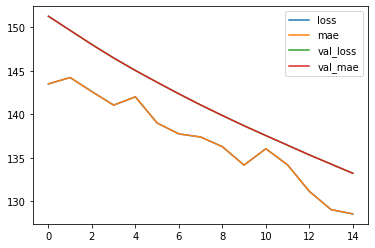

1/1 [==============================] - 0s 328ms/step - loss: 138.2988 - mae: 138.2988
[138.29884338378906, 138.29884338378906]
1/1 [==============================] - 0s 255ms/step
receta 0 kcal_true: 1297.0 kcal_pred: 939.1474  precisión: 72.4 %
receta 0 carbohydrate_true: 39.66 carbohydrate_pred: 22.989847  precisión: 58.0 %
receta 0 protein_true: 121.3 protein_pred: 76.70898  precisión: 63.2 %
receta 0 total_fat_true: 71.0 total_fat_pred: 35.85535  precisión: 50.5 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1567.0 kcal_pred: 984.3122  precisión: 62.8 %
receta 1 carbohydrate_true: 61.03 carbohydrate_pred: 39.869278  precisión: 65.3 %
receta 1 protein_true: 66.7 protein_pred: 72.04396  precisión: 92.6 %
receta 1 total_fat_true: 130.6 total_fat_pred: 34.28554  precisión: 26.2 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1324.0 kcal_pred: 823.0045  precisión: 62.2 %
receta 2 carbohy

100%|██████████| 500/500 [01:49<00:00,  4.57it/s]


Epoch 43/57
13/13 [==============================] - 8s 616ms/step - loss: 128.2938 - mae: 128.2938 - val_loss: 133.5679 - val_mae: 133.5679
Epoch 44/57
13/13 [==============================] - 7s 508ms/step - loss: 127.2221 - mae: 127.2221 - val_loss: 132.1070 - val_mae: 132.1070
Epoch 45/57
13/13 [==============================] - 7s 541ms/step - loss: 128.4732 - mae: 128.4732 - val_loss: 130.5720 - val_mae: 130.5720
Epoch 46/57
13/13 [==============================] - 7s 552ms/step - loss: 124.8260 - mae: 124.8260 - val_loss: 129.0721 - val_mae: 129.0721
Epoch 47/57
13/13 [==============================] - 7s 562ms/step - loss: 124.7990 - mae: 124.7990 - val_loss: 127.6688 - val_mae: 127.6688
Epoch 48/57
13/13 [==============================] - 7s 559ms/step - loss: 123.2767 - mae: 123.2767 - val_loss: 126.3522 - val_mae: 126.3522
Epoch 49/57
13/13 [==============================] - 7s 532ms/step - loss: 122.7213 - mae: 122.7213 - val_loss: 125.0957 - val_mae: 125.0957
Epoch 50/57
1

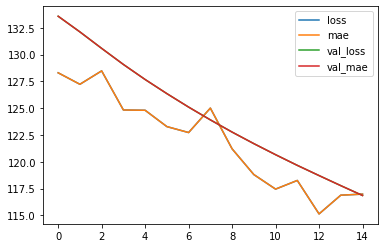

1/1 [==============================] - 0s 242ms/step - loss: 124.7956 - mae: 124.7956
[124.7955551147461, 124.7955551147461]
1/1 [==============================] - 0s 180ms/step
receta 0 kcal_true: 501.5 kcal_pred: 932.51025  precisión: 53.8 %
receta 0 carbohydrate_true: 11.92 carbohydrate_pred: 65.70622  precisión: 18.1 %
receta 0 protein_true: 69.25 protein_pred: 49.00659  precisión: 70.8 %
receta 0 total_fat_true: 17.86 total_fat_pred: 29.934155  precisión: 59.7 %
---------------------------------------------------------------------------
receta 1 kcal_true: 592.0 kcal_pred: 1199.6111  precisión: 49.3 %
receta 1 carbohydrate_true: 128.5 carbohydrate_pred: 220.08484  precisión: 58.4 %
receta 1 protein_true: 11.61 protein_pred: 24.220413  precisión: 47.9 %
receta 1 total_fat_true: 1.65 total_fat_pred: 5.1145997  precisión: 32.3 %
---------------------------------------------------------------------------
receta 2 kcal_true: 537.5 kcal_pred: 949.0735  precisión: 56.6 %
receta 2 carbohy

100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


Epoch 57/71
13/13 [==============================] - 7s 530ms/step - loss: 61.2928 - mae: 61.2928 - val_loss: 54.8443 - val_mae: 54.8443
Epoch 58/71
13/13 [==============================] - 6s 497ms/step - loss: 61.3713 - mae: 61.3713 - val_loss: 54.7785 - val_mae: 54.7785
Epoch 59/71
13/13 [==============================] - 6s 493ms/step - loss: 60.7869 - mae: 60.7869 - val_loss: 54.6992 - val_mae: 54.6992
Epoch 60/71
13/13 [==============================] - 7s 540ms/step - loss: 60.8747 - mae: 60.8747 - val_loss: 54.6236 - val_mae: 54.6236
Epoch 61/71
13/13 [==============================] - 7s 546ms/step - loss: 60.1396 - mae: 60.1396 - val_loss: 54.5575 - val_mae: 54.5575
Epoch 62/71
13/13 [==============================] - 7s 545ms/step - loss: 63.7285 - mae: 63.7285 - val_loss: 54.5022 - val_mae: 54.5022
Epoch 63/71
13/13 [==============================] - 7s 550ms/step - loss: 60.0491 - mae: 60.0491 - val_loss: 54.4422 - val_mae: 54.4422
Epoch 64/71
13/13 [======================

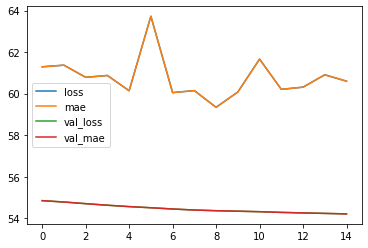

1/1 [==============================] - 0s 305ms/step - loss: 56.7513 - mae: 56.7513
[56.75129318237305, 56.75129318237305]
1/1 [==============================] - 0s 184ms/step
receta 0 kcal_true: 1159.0 kcal_pred: 854.49084  precisión: 73.7 %
receta 0 carbohydrate_true: 4.58 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 0 protein_true: 82.44 protein_pred: 86.313  precisión: 95.5 %
receta 0 total_fat_true: 89.56 total_fat_pred: 33.09446  precisión: 37.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 994.5 kcal_pred: 983.8458  precisión: 98.9 %
receta 1 carbohydrate_true: 52.9 carbohydrate_pred: 98.96524  precisión: 53.5 %
receta 1 protein_true: 18.94 protein_pred: 42.275284  precisión: 44.8 %
receta 1 total_fat_true: 79.6 total_fat_pred: 25.751156  precisión: 32.3 %
---------------------------------------------------------------------------
receta 2 kcal_true: 819.5 kcal_pred: 900.5531  precisión: 91.0 %
receta 2 carbohydrate_true: 98

100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


Epoch 71/85
13/13 [==============================] - 7s 506ms/step - loss: 141.6628 - mae: 141.6628 - val_loss: 156.5711 - val_mae: 156.5711
Epoch 72/85
13/13 [==============================] - 6s 494ms/step - loss: 141.2179 - mae: 141.2179 - val_loss: 155.3598 - val_mae: 155.3598
Epoch 73/85
13/13 [==============================] - 7s 502ms/step - loss: 137.7617 - mae: 137.7617 - val_loss: 154.0972 - val_mae: 154.0972
Epoch 74/85
13/13 [==============================] - 6s 498ms/step - loss: 137.8377 - mae: 137.8377 - val_loss: 152.8331 - val_mae: 152.8331
Epoch 75/85
13/13 [==============================] - 7s 545ms/step - loss: 136.8161 - mae: 136.8161 - val_loss: 151.5946 - val_mae: 151.5946
Epoch 76/85
13/13 [==============================] - 7s 545ms/step - loss: 140.3464 - mae: 140.3464 - val_loss: 150.3922 - val_mae: 150.3922
Epoch 77/85
13/13 [==============================] - 7s 556ms/step - loss: 137.1829 - mae: 137.1829 - val_loss: 149.2279 - val_mae: 149.2279
Epoch 78/85
1

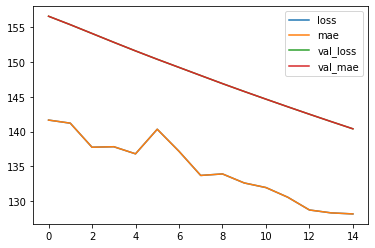

1/1 [==============================] - 0s 256ms/step - loss: 146.2990 - mae: 146.2990
[146.2990264892578, 146.2990264892578]
1/1 [==============================] - 0s 182ms/step
receta 0 kcal_true: 1590.0 kcal_pred: 1183.9237  precisión: 74.5 %
receta 0 carbohydrate_true: 61.12 carbohydrate_pred: 70.454216  precisión: 86.8 %
receta 0 protein_true: 122.6 protein_pred: 72.4968  precisión: 59.1 %
receta 0 total_fat_true: 95.75 total_fat_pred: 40.87402  precisión: 42.7 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1685.0 kcal_pred: 1214.0729  precisión: 72.1 %
receta 1 carbohydrate_true: 114.5 carbohydrate_pred: 20.206451  precisión: 17.6 %
receta 1 protein_true: 47.88 protein_pred: 109.86538  precisión: 43.6 %
receta 1 total_fat_true: 117.56 total_fat_pred: 44.201653  precisión: 37.6 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1416.0 kcal_pred: 1278.8004  precisión: 90.3 %
receta 2 ca

100%|██████████| 500/500 [01:40<00:00,  4.98it/s]


Epoch 85/99
13/13 [==============================] - 7s 502ms/step - loss: 133.4635 - mae: 133.4635 - val_loss: 130.3878 - val_mae: 130.3878
Epoch 86/99
13/13 [==============================] - 6s 490ms/step - loss: 134.1321 - mae: 134.1321 - val_loss: 129.0217 - val_mae: 129.0217
Epoch 87/99
13/13 [==============================] - 7s 519ms/step - loss: 132.6162 - mae: 132.6162 - val_loss: 127.5774 - val_mae: 127.5774
Epoch 88/99
13/13 [==============================] - 7s 510ms/step - loss: 135.1043 - mae: 135.1043 - val_loss: 126.1796 - val_mae: 126.1796
Epoch 89/99
13/13 [==============================] - 7s 541ms/step - loss: 131.4032 - mae: 131.4032 - val_loss: 124.8531 - val_mae: 124.8531
Epoch 90/99
13/13 [==============================] - 7s 543ms/step - loss: 130.4700 - mae: 130.4700 - val_loss: 123.6054 - val_mae: 123.6054
Epoch 91/99
13/13 [==============================] - 7s 541ms/step - loss: 125.4836 - mae: 125.4836 - val_loss: 122.4233 - val_mae: 122.4233
Epoch 92/99
1

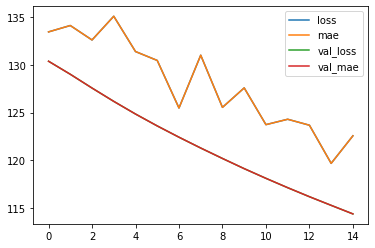

1/1 [==============================] - 0s 252ms/step - loss: 123.4025 - mae: 123.4025
[123.40250396728516, 123.40250396728516]
1/1 [==============================] - 0s 186ms/step
receta 0 kcal_true: 668.5 kcal_pred: 1027.1954  precisión: 65.1 %
receta 0 carbohydrate_true: 106.2 carbohydrate_pred: 43.532513  precisión: 41.0 %
receta 0 protein_true: 35.56 protein_pred: 66.46345  precisión: 53.5 %
receta 0 total_fat_true: 12.75 total_fat_pred: 37.327305  precisión: 34.2 %
---------------------------------------------------------------------------
receta 1 kcal_true: 351.2 kcal_pred: 707.8646  precisión: 49.6 %
receta 1 carbohydrate_true: 6.17 carbohydrate_pred: 35.587513  precisión: 17.3 %
receta 1 protein_true: 13.28 protein_pred: 49.56031  precisión: 26.8 %
receta 1 total_fat_true: 34.06 total_fat_pred: 25.114147  precisión: 73.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 364.5 kcal_pred: 887.2553  precisión: 41.1 %
receta 2 carboh

100%|██████████| 500/500 [01:48<00:00,  4.59it/s]


Epoch 99/113
13/13 [==============================] - 8s 581ms/step - loss: 61.4642 - mae: 61.4642 - val_loss: 57.7861 - val_mae: 57.7861
Epoch 100/113
13/13 [==============================] - 8s 611ms/step - loss: 63.4124 - mae: 63.4124 - val_loss: 57.7911 - val_mae: 57.7911
Epoch 101/113
13/13 [==============================] - 7s 573ms/step - loss: 63.5359 - mae: 63.5359 - val_loss: 57.7902 - val_mae: 57.7902
Epoch 102/113
13/13 [==============================] - 7s 503ms/step - loss: 62.0194 - mae: 62.0194 - val_loss: 57.7856 - val_mae: 57.7856
Epoch 103/113
13/13 [==============================] - 7s 539ms/step - loss: 62.6548 - mae: 62.6548 - val_loss: 57.7842 - val_mae: 57.7842
Epoch 104/113
13/13 [==============================] - 9s 672ms/step - loss: 61.1106 - mae: 61.1106 - val_loss: 57.7834 - val_mae: 57.7834
Epoch 105/113
13/13 [==============================] - 8s 638ms/step - loss: 62.7061 - mae: 62.7061 - val_loss: 57.7818 - val_mae: 57.7818
Epoch 106/113
13/13 [=======

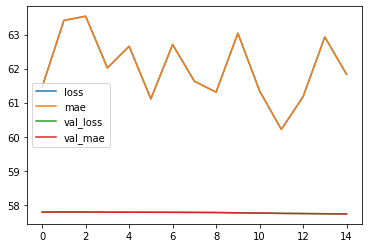

1/1 [==============================] - 0s 363ms/step - loss: 47.7067 - mae: 47.7067
[47.7066764831543, 47.7066764831543]
1/1 [==============================] - 0s 287ms/step
receta 0 kcal_true: 1053.0 kcal_pred: 791.9939  precisión: 75.2 %
receta 0 carbohydrate_true: 28.8 carbohydrate_pred: 2.8322697  precisión: 9.8 %
receta 0 protein_true: 85.25 protein_pred: 72.95749  precisión: 85.6 %
receta 0 total_fat_true: 66.5 total_fat_pred: 32.026203  precisión: 48.2 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1047.0 kcal_pred: 1154.6178  precisión: 90.7 %
receta 1 carbohydrate_true: 247.9 carbohydrate_pred: 201.21678  precisión: 81.2 %
receta 1 protein_true: 7.0 protein_pred: 25.557056  precisión: 27.4 %
receta 1 total_fat_true: 3.44 total_fat_pred: 8.38185  precisión: 41.0 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1017.5 kcal_pred: 1015.04  precisión: 99.8 %
receta 2 carbohydrate_tru

100%|██████████| 500/500 [01:48<00:00,  4.60it/s]


Epoch 113/127
13/13 [==============================] - 7s 516ms/step - loss: 142.7070 - mae: 142.7070 - val_loss: 151.7898 - val_mae: 151.7898
Epoch 114/127
13/13 [==============================] - 7s 551ms/step - loss: 144.8369 - mae: 144.8369 - val_loss: 150.4999 - val_mae: 150.4999
Epoch 115/127
13/13 [==============================] - 7s 556ms/step - loss: 142.7066 - mae: 142.7066 - val_loss: 149.1580 - val_mae: 149.1580
Epoch 116/127
13/13 [==============================] - 8s 644ms/step - loss: 139.0595 - mae: 139.0595 - val_loss: 147.8337 - val_mae: 147.8337
Epoch 117/127
13/13 [==============================] - 8s 632ms/step - loss: 143.1106 - mae: 143.1106 - val_loss: 146.5331 - val_mae: 146.5331
Epoch 118/127
13/13 [==============================] - 8s 630ms/step - loss: 136.6518 - mae: 136.6518 - val_loss: 145.2652 - val_mae: 145.2652
Epoch 119/127
13/13 [==============================] - 8s 631ms/step - loss: 134.3421 - mae: 134.3421 - val_loss: 144.0474 - val_mae: 144.0474

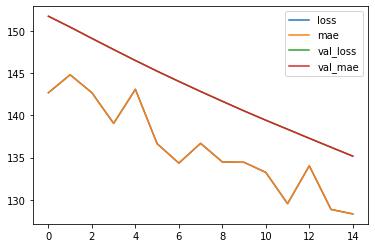

1/1 [==============================] - 0s 370ms/step - loss: 148.8265 - mae: 148.8265
[148.82647705078125, 148.82647705078125]
1/1 [==============================] - 0s 273ms/step
receta 0 kcal_true: 1375.0 kcal_pred: 1099.4196  precisión: 80.0 %
receta 0 carbohydrate_true: 319.8 carbohydrate_pred: 124.78751  precisión: 39.0 %
receta 0 protein_true: 9.03 protein_pred: 42.28698  precisión: 21.4 %
receta 0 total_fat_true: 12.29 total_fat_pred: 26.52565  precisión: 46.3 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1565.0 kcal_pred: 1239.449  precisión: 79.2 %
receta 1 carbohydrate_true: 129.2 carbohydrate_pred: 92.19477  precisión: 71.3 %
receta 1 protein_true: 169.5 protein_pred: 60.54457  precisión: 35.7 %
receta 1 total_fat_true: 43.38 total_fat_pred: 41.624268  precisión: 96.0 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1624.0 kcal_pred: 982.01276  precisión: 60.5 %
receta 2 carb

100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


Epoch 127/141
13/13 [==============================] - 9s 669ms/step - loss: 128.0263 - mae: 128.0263 - val_loss: 135.8148 - val_mae: 135.8148
Epoch 128/141
13/13 [==============================] - 8s 596ms/step - loss: 129.3236 - mae: 129.3236 - val_loss: 134.2077 - val_mae: 134.2077
Epoch 129/141
13/13 [==============================] - 7s 565ms/step - loss: 128.2192 - mae: 128.2192 - val_loss: 132.5596 - val_mae: 132.5596
Epoch 130/141
13/13 [==============================] - 7s 561ms/step - loss: 124.8026 - mae: 124.8026 - val_loss: 130.9794 - val_mae: 130.9794
Epoch 131/141
13/13 [==============================] - 7s 551ms/step - loss: 125.0950 - mae: 125.0950 - val_loss: 129.4744 - val_mae: 129.4744
Epoch 132/141
13/13 [==============================] - 7s 545ms/step - loss: 125.1072 - mae: 125.1072 - val_loss: 128.0515 - val_mae: 128.0515
Epoch 133/141
13/13 [==============================] - 7s 543ms/step - loss: 126.6286 - mae: 126.6286 - val_loss: 126.6877 - val_mae: 126.6877

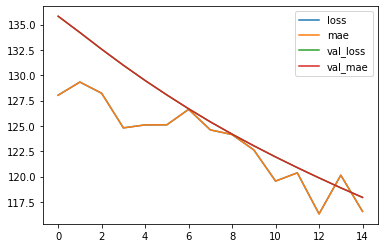

1/1 [==============================] - 0s 299ms/step - loss: 133.8835 - mae: 133.8835
[133.88345336914062, 133.88345336914062]
1/1 [==============================] - 0s 182ms/step
receta 0 kcal_true: 609.5 kcal_pred: 1028.691  precisión: 59.3 %
receta 0 carbohydrate_true: 156.5 carbohydrate_pred: 180.63367  precisión: 86.6 %
receta 0 protein_true: 1.79 protein_pred: 22.857412  precisión: 7.8 %
receta 0 total_fat_true: 0.49 total_fat_pred: 7.3332524  precisión: 6.7 %
---------------------------------------------------------------------------
receta 1 kcal_true: 428.5 kcal_pred: 942.03845  precisión: 45.5 %
receta 1 carbohydrate_true: 47.72 carbohydrate_pred: 90.66402  precisión: 52.6 %
receta 1 protein_true: 33.06 protein_pred: 40.836002  precisión: 81.0 %
receta 1 total_fat_true: 11.62 total_fat_pred: 26.286163  precisión: 44.2 %
---------------------------------------------------------------------------
receta 2 kcal_true: 585.5 kcal_pred: 1097.0349  precisión: 53.4 %
receta 2 carbohy

100%|██████████| 500/500 [01:57<00:00,  4.26it/s]


Epoch 141/155
13/13 [==============================] - 9s 615ms/step - loss: 60.0458 - mae: 60.0458 - val_loss: 59.7151 - val_mae: 59.7151
Epoch 142/155
13/13 [==============================] - 7s 504ms/step - loss: 58.0589 - mae: 58.0589 - val_loss: 59.7349 - val_mae: 59.7349
Epoch 143/155
13/13 [==============================] - 7s 568ms/step - loss: 58.5683 - mae: 58.5683 - val_loss: 59.7416 - val_mae: 59.7416
Epoch 144/155
13/13 [==============================] - 7s 573ms/step - loss: 59.6950 - mae: 59.6950 - val_loss: 59.7526 - val_mae: 59.7526
Epoch 145/155
13/13 [==============================] - 7s 521ms/step - loss: 58.2188 - mae: 58.2188 - val_loss: 59.7603 - val_mae: 59.7603
Epoch 146/155
13/13 [==============================] - 7s 558ms/step - loss: 57.2926 - mae: 57.2926 - val_loss: 59.7593 - val_mae: 59.7593
Epoch 147/155
13/13 [==============================] - 7s 571ms/step - loss: 57.8512 - mae: 57.8512 - val_loss: 59.7561 - val_mae: 59.7561
Epoch 148/155
13/13 [======

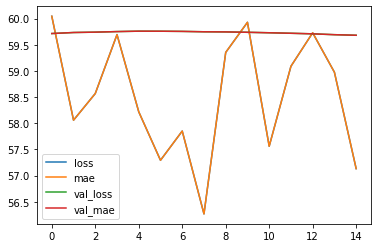

1/1 [==============================] - 0s 257ms/step - loss: 60.2664 - mae: 60.2664
[60.26636505126953, 60.26636505126953]
1/1 [==============================] - 0s 186ms/step
receta 0 kcal_true: 975.5 kcal_pred: 843.76447  precisión: 86.5 %
receta 0 carbohydrate_true: 19.44 carbohydrate_pred: 18.278301  precisión: 94.0 %
receta 0 protein_true: 53.16 protein_pred: 72.73641  precisión: 73.1 %
receta 0 total_fat_true: 76.4 total_fat_pred: 32.678474  precisión: 42.8 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1182.0 kcal_pred: 798.1656  precisión: 67.5 %
receta 1 carbohydrate_true: 25.52 carbohydrate_pred: 52.984203  precisión: 48.2 %
receta 1 protein_true: 147.5 protein_pred: 43.936207  precisión: 29.8 %
receta 1 total_fat_true: 50.72 total_fat_pred: 27.14792  precisión: 53.5 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1103.0 kcal_pred: 1210.3726  precisión: 91.1 %
receta 2 carbohy

100%|██████████| 500/500 [02:01<00:00,  4.13it/s]


Epoch 155/169
13/13 [==============================] - 9s 632ms/step - loss: 151.2538 - mae: 151.2538 - val_loss: 149.4572 - val_mae: 149.4572
Epoch 156/169
13/13 [==============================] - 8s 630ms/step - loss: 146.3957 - mae: 146.3957 - val_loss: 148.2513 - val_mae: 148.2513
Epoch 157/169
13/13 [==============================] - 7s 557ms/step - loss: 144.4879 - mae: 144.4879 - val_loss: 146.9898 - val_mae: 146.9898
Epoch 158/169
13/13 [==============================] - 7s 579ms/step - loss: 144.9008 - mae: 144.9008 - val_loss: 145.7365 - val_mae: 145.7365
Epoch 159/169
13/13 [==============================] - 7s 550ms/step - loss: 144.1375 - mae: 144.1375 - val_loss: 144.5358 - val_mae: 144.5358
Epoch 160/169
13/13 [==============================] - 7s 548ms/step - loss: 142.7963 - mae: 142.7963 - val_loss: 143.3703 - val_mae: 143.3703
Epoch 161/169
13/13 [==============================] - 7s 547ms/step - loss: 140.1485 - mae: 140.1485 - val_loss: 142.2375 - val_mae: 142.2375

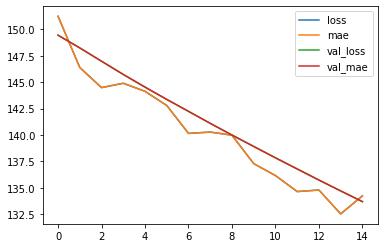

1/1 [==============================] - 0s 293ms/step - loss: 137.2497 - mae: 137.2497
[137.24972534179688, 137.24972534179688]
1/1 [==============================] - 0s 190ms/step
receta 0 kcal_true: 1604.0 kcal_pred: 1168.577  precisión: 72.9 %
receta 0 carbohydrate_true: 410.8 carbohydrate_pred: 218.88573  precisión: 53.3 %
receta 0 protein_true: 2.46 protein_pred: 22.983881  precisión: 10.7 %
receta 0 total_fat_true: 1.58 total_fat_pred: 5.8525662  precisión: 27.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1574.0 kcal_pred: 1173.2943  precisión: 74.5 %
receta 1 carbohydrate_true: 124.8 carbohydrate_pred: 25.84764  precisión: 20.7 %
receta 1 protein_true: 113.56 protein_pred: 87.93702  precisión: 77.4 %
receta 1 total_fat_true: 52.3 total_fat_pred: 49.130024  precisión: 93.9 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1470.0 kcal_pred: 953.3028  precisión: 64.9 %
receta 2 carb

100%|██████████| 500/500 [01:49<00:00,  4.59it/s]


Epoch 169/183
13/13 [==============================] - 8s 542ms/step - loss: 130.3773 - mae: 130.3773 - val_loss: 129.5539 - val_mae: 129.5539
Epoch 170/183
13/13 [==============================] - 7s 574ms/step - loss: 132.7826 - mae: 132.7826 - val_loss: 128.3282 - val_mae: 128.3282
Epoch 171/183
13/13 [==============================] - 8s 648ms/step - loss: 131.8757 - mae: 131.8757 - val_loss: 126.9976 - val_mae: 126.9976
Epoch 172/183
13/13 [==============================] - 7s 570ms/step - loss: 129.9155 - mae: 129.9155 - val_loss: 125.6879 - val_mae: 125.6879
Epoch 173/183
13/13 [==============================] - 8s 632ms/step - loss: 129.5402 - mae: 129.5402 - val_loss: 124.4283 - val_mae: 124.4283
Epoch 174/183
13/13 [==============================] - 7s 554ms/step - loss: 126.8298 - mae: 126.8298 - val_loss: 123.2224 - val_mae: 123.2224
Epoch 175/183
13/13 [==============================] - 8s 596ms/step - loss: 127.9908 - mae: 127.9908 - val_loss: 122.0520 - val_mae: 122.0520

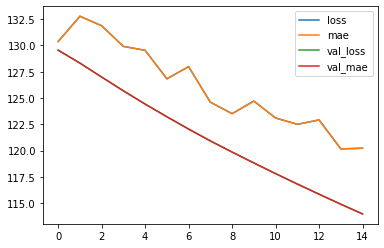

1/1 [==============================] - 0s 379ms/step - loss: 124.0651 - mae: 124.0651
[124.06513977050781, 124.06513977050781]
1/1 [==============================] - 0s 276ms/step
receta 0 kcal_true: 401.0 kcal_pred: 1050.6404  precisión: 38.2 %
receta 0 carbohydrate_true: 79.94 carbohydrate_pred: 153.1807  precisión: 52.2 %
receta 0 protein_true: 20.2 protein_pred: 31.14552  precisión: 64.9 %
receta 0 total_fat_true: 4.92 total_fat_pred: 16.214808  precisión: 30.4 %
---------------------------------------------------------------------------
receta 1 kcal_true: 425.0 kcal_pred: 917.1671  precisión: 46.3 %
receta 1 carbohydrate_true: 57.12 carbohydrate_pred: 128.14488  precisión: 44.6 %
receta 1 protein_true: 15.1 protein_pred: 28.3232  precisión: 53.3 %
receta 1 total_fat_true: 16.56 total_fat_pred: 16.261738  precisión: 98.2 %
---------------------------------------------------------------------------
receta 2 kcal_true: 446.0 kcal_pred: 974.2938  precisión: 45.8 %
receta 2 carbohydra

100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


Epoch 183/197
13/13 [==============================] - 8s 560ms/step - loss: 62.6232 - mae: 62.6232 - val_loss: 48.2267 - val_mae: 48.2267
Epoch 184/197
13/13 [==============================] - 7s 544ms/step - loss: 61.9617 - mae: 61.9617 - val_loss: 48.2279 - val_mae: 48.2279
Epoch 185/197
13/13 [==============================] - 8s 604ms/step - loss: 60.3862 - mae: 60.3862 - val_loss: 48.2304 - val_mae: 48.2304
Epoch 186/197
13/13 [==============================] - 7s 569ms/step - loss: 61.0595 - mae: 61.0595 - val_loss: 48.2344 - val_mae: 48.2344
Epoch 187/197
13/13 [==============================] - 8s 653ms/step - loss: 63.8389 - mae: 63.8389 - val_loss: 48.2394 - val_mae: 48.2394
Epoch 188/197
13/13 [==============================] - 8s 598ms/step - loss: 60.7303 - mae: 60.7303 - val_loss: 48.2557 - val_mae: 48.2557
Epoch 189/197
13/13 [==============================] - 8s 641ms/step - loss: 62.0204 - mae: 62.0204 - val_loss: 48.2723 - val_mae: 48.2723
Epoch 190/197
13/13 [======

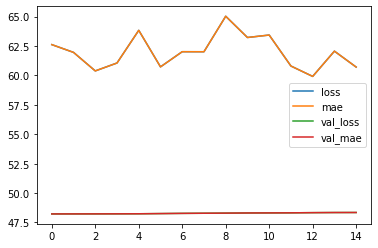

1/1 [==============================] - 0s 365ms/step - loss: 52.8636 - mae: 52.8636
[52.863624572753906, 52.863624572753906]
1/1 [==============================] - 0s 270ms/step
receta 0 kcal_true: 810.0 kcal_pred: 916.4474  precisión: 88.4 %
receta 0 carbohydrate_true: 57.9 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 0 protein_true: 76.44 protein_pred: 85.51367  precisión: 89.4 %
receta 0 total_fat_true: 32.7 total_fat_pred: 37.38563  precisión: 87.4 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1166.0 kcal_pred: 969.80835  precisión: 83.2 %
receta 1 carbohydrate_true: 241.9 carbohydrate_pred: 90.02723  precisión: 37.2 %
receta 1 protein_true: 26.98 protein_pred: 43.43631  precisión: 62.1 %
receta 1 total_fat_true: 14.58 total_fat_pred: 27.986357  precisión: 52.1 %
---------------------------------------------------------------------------
receta 2 kcal_true: 979.0 kcal_pred: 1144.1511  precisión: 85.6 %
receta 2 carbohydrate_tru

100%|██████████| 500/500 [01:59<00:00,  4.19it/s]


Epoch 197/211
13/13 [==============================] - 8s 547ms/step - loss: 141.2335 - mae: 141.2335 - val_loss: 146.6662 - val_mae: 146.6662
Epoch 198/211
13/13 [==============================] - 7s 530ms/step - loss: 142.4556 - mae: 142.4556 - val_loss: 145.6762 - val_mae: 145.6762
Epoch 199/211
13/13 [==============================] - 7s 574ms/step - loss: 140.5670 - mae: 140.5670 - val_loss: 144.5928 - val_mae: 144.5928
Epoch 200/211
13/13 [==============================] - 8s 618ms/step - loss: 142.5509 - mae: 142.5509 - val_loss: 143.4992 - val_mae: 143.4992
Epoch 201/211
13/13 [==============================] - 8s 636ms/step - loss: 139.1388 - mae: 139.1388 - val_loss: 142.4138 - val_mae: 142.4138
Epoch 202/211
13/13 [==============================] - 7s 546ms/step - loss: 141.2587 - mae: 141.2587 - val_loss: 141.3443 - val_mae: 141.3443
Epoch 203/211
13/13 [==============================] - 8s 603ms/step - loss: 137.5397 - mae: 137.5397 - val_loss: 140.2769 - val_mae: 140.2769

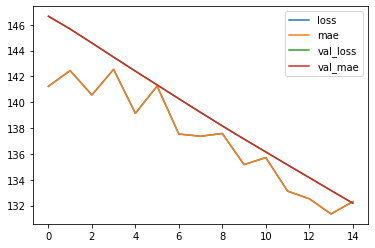

1/1 [==============================] - 0s 317ms/step - loss: 131.3854 - mae: 131.3854
[131.3854217529297, 131.3854217529297]
1/1 [==============================] - 0s 208ms/step
receta 0 kcal_true: 1202.0 kcal_pred: 1115.9181  precisión: 92.8 %
receta 0 carbohydrate_true: 21.19 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 0 protein_true: 178.2 protein_pred: 117.80602  precisión: 66.1 %
receta 0 total_fat_true: 40.22 total_fat_pred: 42.892212  precisión: 93.8 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1382.0 kcal_pred: 954.98517  precisión: 69.1 %
receta 1 carbohydrate_true: 292.0 carbohydrate_pred: 124.701485  precisión: 42.7 %
receta 1 protein_true: 32.0 protein_pred: 33.034863  precisión: 96.9 %
receta 1 total_fat_true: 7.12 total_fat_pred: 19.703321  precisión: 36.1 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1582.0 kcal_pred: 1166.4438  precisión: 73.7 %
receta 2 carbohyd

100%|██████████| 500/500 [01:56<00:00,  4.27it/s]


Epoch 211/225
13/13 [==============================] - 7s 533ms/step - loss: 131.4460 - mae: 131.4460 - val_loss: 130.0694 - val_mae: 130.0694
Epoch 212/225
13/13 [==============================] - 7s 507ms/step - loss: 131.6014 - mae: 131.6014 - val_loss: 128.9268 - val_mae: 128.9268
Epoch 213/225
13/13 [==============================] - 7s 507ms/step - loss: 129.5276 - mae: 129.5276 - val_loss: 127.6783 - val_mae: 127.6783
Epoch 214/225
13/13 [==============================] - 7s 554ms/step - loss: 128.0180 - mae: 128.0180 - val_loss: 126.4417 - val_mae: 126.4417
Epoch 215/225
13/13 [==============================] - 7s 540ms/step - loss: 125.9243 - mae: 125.9243 - val_loss: 125.2547 - val_mae: 125.2547
Epoch 216/225
13/13 [==============================] - 7s 538ms/step - loss: 128.8561 - mae: 128.8561 - val_loss: 124.1240 - val_mae: 124.1240
Epoch 217/225
13/13 [==============================] - 7s 523ms/step - loss: 127.4065 - mae: 127.4065 - val_loss: 123.0368 - val_mae: 123.0368

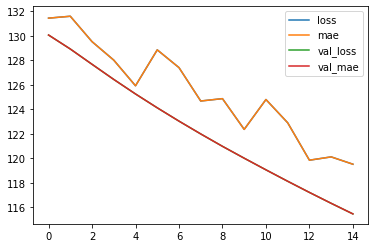

1/1 [==============================] - 0s 286ms/step - loss: 120.3067 - mae: 120.3067
[120.3066635131836, 120.3066635131836]
1/1 [==============================] - 0s 224ms/step
receta 0 kcal_true: 443.0 kcal_pred: 936.97125  precisión: 47.3 %
receta 0 carbohydrate_true: 1.1 carbohydrate_pred: 49.67627  precisión: 2.2 %
receta 0 protein_true: 54.22 protein_pred: 53.31975  precisión: 98.3 %
receta 0 total_fat_true: 23.56 total_fat_pred: 36.18356  precisión: 65.1 %
---------------------------------------------------------------------------
receta 1 kcal_true: 319.8 kcal_pred: 1017.16736  precisión: 31.4 %
receta 1 carbohydrate_true: 0.37 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 1 protein_true: 60.03 protein_pred: 108.42656  precisión: 55.4 %
receta 1 total_fat_true: 8.61 total_fat_pred: 39.606495  precisión: 21.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 535.5 kcal_pred: 1034.1771  precisión: 51.8 %
receta 2 carbohydrate_true

100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


Epoch 225/239
13/13 [==============================] - 9s 658ms/step - loss: 60.8943 - mae: 60.8943 - val_loss: 56.1064 - val_mae: 56.1064
Epoch 226/239
13/13 [==============================] - 7s 551ms/step - loss: 61.3316 - mae: 61.3316 - val_loss: 56.1084 - val_mae: 56.1084
Epoch 227/239
13/13 [==============================] - 7s 523ms/step - loss: 62.7210 - mae: 62.7210 - val_loss: 56.1041 - val_mae: 56.1041
Epoch 228/239
13/13 [==============================] - 7s 555ms/step - loss: 60.6941 - mae: 60.6941 - val_loss: 56.0890 - val_mae: 56.0890
Epoch 229/239
13/13 [==============================] - 9s 708ms/step - loss: 61.7440 - mae: 61.7440 - val_loss: 56.0690 - val_mae: 56.0690
Epoch 230/239
13/13 [==============================] - 8s 643ms/step - loss: 59.9477 - mae: 59.9477 - val_loss: 56.0483 - val_mae: 56.0483
Epoch 231/239
13/13 [==============================] - 9s 635ms/step - loss: 59.3025 - mae: 59.3025 - val_loss: 56.0344 - val_mae: 56.0344
Epoch 232/239
13/13 [======

100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


Epoch 225/239
13/13 [==============================] - 7s 540ms/step - loss: 142.3786 - mae: 142.3786 - val_loss: 152.0844 - val_mae: 152.0844
Epoch 226/239
13/13 [==============================] - 7s 527ms/step - loss: 142.3189 - mae: 142.3189 - val_loss: 150.8270 - val_mae: 150.8270
Epoch 227/239
13/13 [==============================] - 8s 567ms/step - loss: 141.9639 - mae: 141.9639 - val_loss: 149.4657 - val_mae: 149.4657
Epoch 228/239
13/13 [==============================] - 7s 504ms/step - loss: 140.8190 - mae: 140.8190 - val_loss: 148.1082 - val_mae: 148.1082
Epoch 229/239
13/13 [==============================] - 8s 588ms/step - loss: 141.4954 - mae: 141.4954 - val_loss: 146.8026 - val_mae: 146.8026
Epoch 230/239
13/13 [==============================] - 7s 555ms/step - loss: 140.3522 - mae: 140.3522 - val_loss: 145.5412 - val_mae: 145.5412
Epoch 231/239
13/13 [==============================] - 7s 535ms/step - loss: 136.6351 - mae: 136.6351 - val_loss: 144.3178 - val_mae: 144.3178

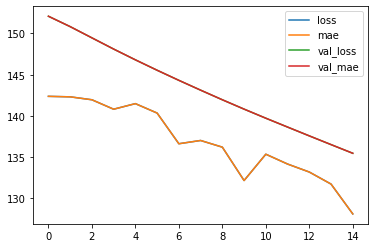

1/1 [==============================] - 0s 341ms/step - loss: 138.5648 - mae: 138.5648
[138.56475830078125, 138.56475830078125]
1/1 [==============================] - 0s 195ms/step
receta 0 kcal_true: 1567.0 kcal_pred: 997.67236  precisión: 63.7 %
receta 0 carbohydrate_true: 354.5 carbohydrate_pred: 62.238777  precisión: 17.6 %
receta 0 protein_true: 83.6 protein_pred: 52.906364  precisión: 63.3 %
receta 0 total_fat_true: 23.98 total_fat_pred: 37.283627  precisión: 64.3 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1553.0 kcal_pred: 1160.184  precisión: 74.7 %
receta 1 carbohydrate_true: 249.0 carbohydrate_pred: 105.381226  precisión: 42.3 %
receta 1 protein_true: 96.8 protein_pred: 51.16198  precisión: 52.8 %
receta 1 total_fat_true: 38.16 total_fat_pred: 35.372612  precisión: 92.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1264.0 kcal_pred: 1124.2489  precisión: 88.9 %
receta 2 c

100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


Epoch 239/253
13/13 [==============================] - 8s 584ms/step - loss: 125.1794 - mae: 125.1794 - val_loss: 132.0181 - val_mae: 132.0181
Epoch 240/253
13/13 [==============================] - 8s 575ms/step - loss: 128.2128 - mae: 128.2128 - val_loss: 130.2877 - val_mae: 130.2877
Epoch 241/253
13/13 [==============================] - 7s 505ms/step - loss: 128.9496 - mae: 128.9496 - val_loss: 128.5358 - val_mae: 128.5358
Epoch 242/253
13/13 [==============================] - 7s 541ms/step - loss: 125.4321 - mae: 125.4321 - val_loss: 126.8705 - val_mae: 126.8705
Epoch 243/253
13/13 [==============================] - 7s 511ms/step - loss: 122.3432 - mae: 122.3432 - val_loss: 125.3192 - val_mae: 125.3192
Epoch 244/253
13/13 [==============================] - 7s 531ms/step - loss: 125.9777 - mae: 125.9777 - val_loss: 123.8705 - val_mae: 123.8705
Epoch 245/253
13/13 [==============================] - 7s 537ms/step - loss: 124.0002 - mae: 124.0002 - val_loss: 122.5001 - val_mae: 122.5001

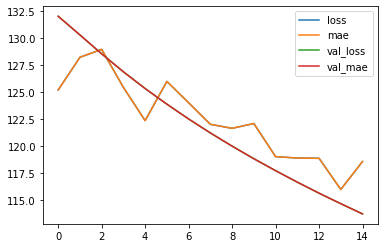

1/1 [==============================] - 0s 249ms/step - loss: 120.0843 - mae: 120.0843
[120.08427429199219, 120.08427429199219]
1/1 [==============================] - 0s 179ms/step
receta 0 kcal_true: 373.0 kcal_pred: 922.79785  precisión: 40.4 %
receta 0 carbohydrate_true: 96.06 carbohydrate_pred: 79.62131  precisión: 82.9 %
receta 0 protein_true: 3.54 protein_pred: 41.7588  precisión: 8.5 %
receta 0 total_fat_true: 1.26 total_fat_pred: 29.10005  precisión: 4.3 %
---------------------------------------------------------------------------
receta 1 kcal_true: 380.2 kcal_pred: 912.3391  precisión: 41.7 %
receta 1 carbohydrate_true: 44.5 carbohydrate_pred: 119.713104  precisión: 37.2 %
receta 1 protein_true: 24.31 protein_pred: 30.845407  precisión: 78.8 %
receta 1 total_fat_true: 14.07 total_fat_pred: 18.163898  precisión: 77.5 %
---------------------------------------------------------------------------
receta 2 kcal_true: 308.0 kcal_pred: 880.1217  precisión: 35.0 %
receta 2 carbohydrat

100%|██████████| 500/500 [01:50<00:00,  4.51it/s]


Epoch 253/267
13/13 [==============================] - 7s 520ms/step - loss: 63.4132 - mae: 63.4132 - val_loss: 47.3761 - val_mae: 47.3761
Epoch 254/267
13/13 [==============================] - 6s 493ms/step - loss: 61.6527 - mae: 61.6527 - val_loss: 47.2864 - val_mae: 47.2864
Epoch 255/267
13/13 [==============================] - 7s 540ms/step - loss: 62.1578 - mae: 62.1578 - val_loss: 47.1999 - val_mae: 47.1999
Epoch 256/267
13/13 [==============================] - 9s 665ms/step - loss: 62.6072 - mae: 62.6072 - val_loss: 47.1332 - val_mae: 47.1332
Epoch 257/267
13/13 [==============================] - 7s 568ms/step - loss: 60.3331 - mae: 60.3331 - val_loss: 47.0696 - val_mae: 47.0696
Epoch 258/267
13/13 [==============================] - 7s 556ms/step - loss: 62.5236 - mae: 62.5236 - val_loss: 47.0243 - val_mae: 47.0243
Epoch 259/267
13/13 [==============================] - 8s 614ms/step - loss: 62.6288 - mae: 62.6288 - val_loss: 46.9786 - val_mae: 46.9786
Epoch 260/267
13/13 [======

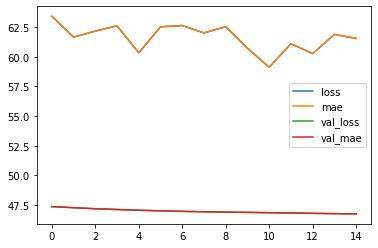

1/1 [==============================] - 0s 242ms/step - loss: 55.8084 - mae: 55.8084
[55.80841827392578, 55.80841827392578]
1/1 [==============================] - 0s 193ms/step
receta 0 kcal_true: 1125.0 kcal_pred: 1009.02405  precisión: 89.7 %
receta 0 carbohydrate_true: 199.6 carbohydrate_pred: 96.21835  precisión: 48.2 %
receta 0 protein_true: 8.59 protein_pred: 42.953255  precisión: 20.0 %
receta 0 total_fat_true: 42.9 total_fat_pred: 29.22632  precisión: 68.1 %
---------------------------------------------------------------------------
receta 1 kcal_true: 847.5 kcal_pred: 849.911  precisión: 99.7 %
receta 1 carbohydrate_true: 140.8 carbohydrate_pred: 65.97577  precisión: 46.9 %
receta 1 protein_true: 21.6 protein_pred: 42.56656  precisión: 50.7 %
receta 1 total_fat_true: 29.0 total_fat_pred: 27.90151  precisión: 96.2 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1198.0 kcal_pred: 996.28894  precisión: 83.2 %
receta 2 carbohydrate_

100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Epoch 267/281
13/13 [==============================] - 8s 532ms/step - loss: 141.1665 - mae: 141.1665 - val_loss: 139.0754 - val_mae: 139.0754
Epoch 268/281
13/13 [==============================] - 8s 624ms/step - loss: 140.7083 - mae: 140.7083 - val_loss: 137.9815 - val_mae: 137.9815
Epoch 269/281
13/13 [==============================] - 7s 509ms/step - loss: 137.4561 - mae: 137.4561 - val_loss: 136.8219 - val_mae: 136.8219
Epoch 270/281
13/13 [==============================] - 7s 543ms/step - loss: 137.9148 - mae: 137.9148 - val_loss: 135.6863 - val_mae: 135.6863
Epoch 271/281
13/13 [==============================] - 9s 677ms/step - loss: 136.3880 - mae: 136.3880 - val_loss: 134.5750 - val_mae: 134.5750
Epoch 272/281
13/13 [==============================] - 8s 657ms/step - loss: 134.3122 - mae: 134.3122 - val_loss: 133.5004 - val_mae: 133.5004
Epoch 273/281
13/13 [==============================] - 7s 572ms/step - loss: 133.5732 - mae: 133.5732 - val_loss: 132.4539 - val_mae: 132.4539

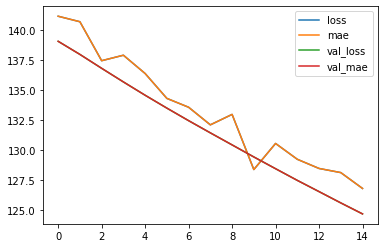

1/1 [==============================] - 0s 261ms/step - loss: 138.3650 - mae: 138.3650
[138.36495971679688, 138.36495971679688]
1/1 [==============================] - 0s 205ms/step
receta 0 kcal_true: 1331.0 kcal_pred: 890.57196  precisión: 66.9 %
receta 0 carbohydrate_true: 40.44 carbohydrate_pred: 62.306435  precisión: 64.9 %
receta 0 protein_true: 252.1 protein_pred: 46.262733  precisión: 18.3 %
receta 0 total_fat_true: 11.23 total_fat_pred: 31.55036  precisión: 35.6 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1437.0 kcal_pred: 1082.7355  precisión: 75.3 %
receta 1 carbohydrate_true: 213.5 carbohydrate_pred: 168.83057  precisión: 79.1 %
receta 1 protein_true: 57.53 protein_pred: 29.27758  precisión: 50.9 %
receta 1 total_fat_true: 43.47 total_fat_pred: 14.973661  precisión: 34.4 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1506.0 kcal_pred: 1285.3063  precisión: 85.3 %
receta 2 

100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


Epoch 281/295
13/13 [==============================] - 8s 557ms/step - loss: 131.2640 - mae: 131.2640 - val_loss: 131.7861 - val_mae: 131.7861
Epoch 282/295
13/13 [==============================] - 7s 534ms/step - loss: 129.2827 - mae: 129.2827 - val_loss: 130.3276 - val_mae: 130.3276
Epoch 283/295
13/13 [==============================] - 8s 592ms/step - loss: 127.8658 - mae: 127.8658 - val_loss: 128.8021 - val_mae: 128.8021
Epoch 284/295
13/13 [==============================] - 8s 608ms/step - loss: 124.5313 - mae: 124.5313 - val_loss: 127.3297 - val_mae: 127.3297
Epoch 285/295
13/13 [==============================] - 7s 537ms/step - loss: 126.0897 - mae: 126.0897 - val_loss: 125.9335 - val_mae: 125.9335
Epoch 286/295
13/13 [==============================] - 7s 562ms/step - loss: 126.3871 - mae: 126.3871 - val_loss: 124.6123 - val_mae: 124.6123
Epoch 287/295
13/13 [==============================] - 8s 594ms/step - loss: 124.5534 - mae: 124.5534 - val_loss: 123.3412 - val_mae: 123.3412

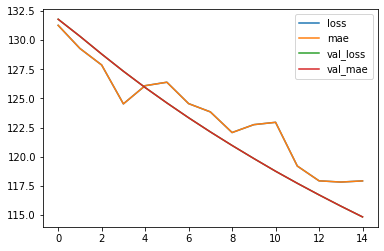

1/1 [==============================] - 0s 367ms/step - loss: 106.1655 - mae: 106.1655
[106.16552734375, 106.16552734375]
1/1 [==============================] - 0s 247ms/step
receta 0 kcal_true: 477.0 kcal_pred: 852.0386  precisión: 56.0 %
receta 0 carbohydrate_true: 99.94 carbohydrate_pred: 119.11325  precisión: 83.9 %
receta 0 protein_true: 15.86 protein_pred: 26.95438  precisión: 58.8 %
receta 0 total_fat_true: 2.75 total_fat_pred: 15.365245  precisión: 17.9 %
---------------------------------------------------------------------------
receta 1 kcal_true: 379.8 kcal_pred: 972.8331  precisión: 39.0 %
receta 1 carbohydrate_true: 20.1 carbohydrate_pred: 118.38847  precisión: 17.0 %
receta 1 protein_true: 7.66 protein_pred: 35.264416  precisión: 21.7 %
receta 1 total_fat_true: 30.12 total_fat_pred: 21.522234  precisión: 71.4 %
---------------------------------------------------------------------------
receta 2 kcal_true: 347.8 kcal_pred: 900.9515  precisión: 38.6 %
receta 2 carbohydrate_t

100%|██████████| 500/500 [01:47<00:00,  4.65it/s]


Epoch 295/309
13/13 [==============================] - 7s 533ms/step - loss: 64.1276 - mae: 64.1276 - val_loss: 50.5308 - val_mae: 50.5308
Epoch 296/309
13/13 [==============================] - 7s 516ms/step - loss: 62.6036 - mae: 62.6036 - val_loss: 50.5538 - val_mae: 50.5538
Epoch 297/309
13/13 [==============================] - 7s 501ms/step - loss: 60.5946 - mae: 60.5946 - val_loss: 50.5839 - val_mae: 50.5839
Epoch 298/309
13/13 [==============================] - 6s 490ms/step - loss: 61.4164 - mae: 61.4164 - val_loss: 50.6092 - val_mae: 50.6092
Epoch 299/309
13/13 [==============================] - 6s 489ms/step - loss: 59.1836 - mae: 59.1836 - val_loss: 50.6305 - val_mae: 50.6305
Epoch 300/309
13/13 [==============================] - 6s 495ms/step - loss: 62.6917 - mae: 62.6917 - val_loss: 50.6504 - val_mae: 50.6504
Epoch 301/309
13/13 [==============================] - 8s 607ms/step - loss: 62.6378 - mae: 62.6378 - val_loss: 50.6642 - val_mae: 50.6642
Epoch 302/309
13/13 [======

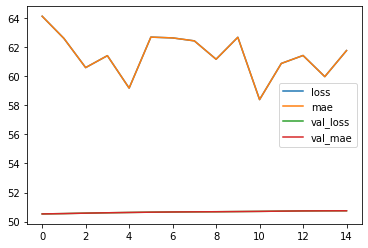

1/1 [==============================] - 0s 289ms/step - loss: 59.0869 - mae: 59.0869
[59.0869140625, 59.0869140625]
1/1 [==============================] - 0s 177ms/step
receta 0 kcal_true: 1013.5 kcal_pred: 1226.4502  precisión: 82.6 %
receta 0 carbohydrate_true: 173.0 carbohydrate_pred: 130.95418  precisión: 75.7 %
receta 0 protein_true: 26.14 protein_pred: 47.943413  precisión: 54.5 %
receta 0 total_fat_true: 24.88 total_fat_pred: 31.28364  precisión: 79.5 %
---------------------------------------------------------------------------
receta 1 kcal_true: 985.0 kcal_pred: 868.3056  precisión: 88.2 %
receta 1 carbohydrate_true: 19.16 carbohydrate_pred: 57.930843  precisión: 33.1 %
receta 1 protein_true: 143.1 protein_pred: 45.917053  precisión: 32.1 %
receta 1 total_fat_true: 37.5 total_fat_pred: 30.875132  precisión: 82.3 %
---------------------------------------------------------------------------
receta 2 kcal_true: 801.0 kcal_pred: 1085.0651  precisión: 73.8 %
receta 2 carbohydrate_tr

100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


Epoch 309/323
13/13 [==============================] - 7s 522ms/step - loss: 142.1381 - mae: 142.1381 - val_loss: 139.2108 - val_mae: 139.2108
Epoch 310/323
13/13 [==============================] - 8s 587ms/step - loss: 139.7202 - mae: 139.7202 - val_loss: 138.2516 - val_mae: 138.2516
Epoch 311/323
13/13 [==============================] - 7s 533ms/step - loss: 140.2851 - mae: 140.2851 - val_loss: 137.2138 - val_mae: 137.2138
Epoch 312/323
13/13 [==============================] - 7s 526ms/step - loss: 141.6978 - mae: 141.6978 - val_loss: 136.1604 - val_mae: 136.1604
Epoch 313/323
13/13 [==============================] - 7s 576ms/step - loss: 135.1774 - mae: 135.1774 - val_loss: 135.1409 - val_mae: 135.1409
Epoch 314/323
13/13 [==============================] - 7s 511ms/step - loss: 135.8114 - mae: 135.8114 - val_loss: 134.1279 - val_mae: 134.1279
Epoch 315/323
13/13 [==============================] - 9s 676ms/step - loss: 137.7219 - mae: 137.7219 - val_loss: 133.1350 - val_mae: 133.1350

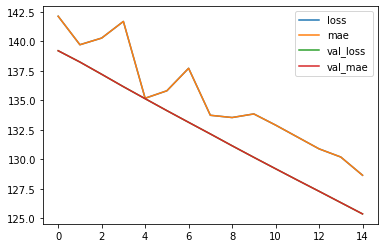

1/1 [==============================] - 0s 322ms/step - loss: 132.0676 - mae: 132.0676
[132.067626953125, 132.067626953125]
1/1 [==============================] - 0s 212ms/step
receta 0 kcal_true: 1389.0 kcal_pred: 1225.6327  precisión: 88.2 %
receta 0 carbohydrate_true: 149.4 carbohydrate_pred: 164.76794  precisión: 90.7 %
receta 0 protein_true: 160.4 protein_pred: 38.60849  precisión: 24.1 %
receta 0 total_fat_true: 14.13 total_fat_pred: 24.200014  precisión: 58.4 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1662.0 kcal_pred: 1140.0175  precisión: 68.6 %
receta 1 carbohydrate_true: 223.0 carbohydrate_pred: 154.80759  precisión: 69.4 %
receta 1 protein_true: 104.9 protein_pred: 35.89126  precisión: 34.2 %
receta 1 total_fat_true: 40.1 total_fat_pred: 22.751152  precisión: 56.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1369.0 kcal_pred: 926.7375  precisión: 67.7 %
receta 2 carboh

100%|██████████| 500/500 [01:52<00:00,  4.44it/s]


Epoch 323/337
13/13 [==============================] - 8s 548ms/step - loss: 137.0275 - mae: 137.0275 - val_loss: 134.3028 - val_mae: 134.3028
Epoch 324/337
13/13 [==============================] - 7s 521ms/step - loss: 135.8391 - mae: 135.8391 - val_loss: 132.9311 - val_mae: 132.9311
Epoch 325/337
13/13 [==============================] - 7s 534ms/step - loss: 137.2647 - mae: 137.2647 - val_loss: 131.4708 - val_mae: 131.4708
Epoch 326/337
13/13 [==============================] - 7s 512ms/step - loss: 137.4571 - mae: 137.4571 - val_loss: 130.0544 - val_mae: 130.0544
Epoch 327/337
13/13 [==============================] - 7s 506ms/step - loss: 134.2040 - mae: 134.2040 - val_loss: 128.6932 - val_mae: 128.6932
Epoch 328/337
13/13 [==============================] - 7s 510ms/step - loss: 131.8656 - mae: 131.8656 - val_loss: 127.4098 - val_mae: 127.4098
Epoch 329/337
13/13 [==============================] - 8s 595ms/step - loss: 133.8496 - mae: 133.8496 - val_loss: 126.1805 - val_mae: 126.1805

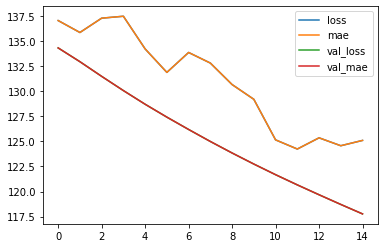

1/1 [==============================] - 0s 248ms/step - loss: 121.5736 - mae: 121.5736
[121.57359313964844, 121.57359313964844]
1/1 [==============================] - 0s 187ms/step
receta 0 kcal_true: 756.5 kcal_pred: 1060.1827  precisión: 71.4 %
receta 0 carbohydrate_true: 69.7 carbohydrate_pred: 94.64899  precisión: 73.6 %
receta 0 protein_true: 70.9 protein_pred: 51.08495  precisión: 72.1 %
receta 0 total_fat_true: 21.42 total_fat_pred: 30.740694  precisión: 69.7 %
---------------------------------------------------------------------------
receta 1 kcal_true: 527.5 kcal_pred: 866.1625  precisión: 60.9 %
receta 1 carbohydrate_true: 0.0 carbohydrate_pred: 39.4758  precisión: 0.0 %
receta 1 protein_true: 1.18 protein_pred: 53.09539  precisión: 2.2 %
receta 1 total_fat_true: 57.94 total_fat_pred: 34.026657  precisión: 58.7 %
---------------------------------------------------------------------------
receta 2 kcal_true: 421.2 kcal_pred: 936.55304  precisión: 45.0 %
receta 2 carbohydrate_t

100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


Epoch 337/351
13/13 [==============================] - 7s 503ms/step - loss: 62.1876 - mae: 62.1876 - val_loss: 56.4170 - val_mae: 56.4170
Epoch 338/351
13/13 [==============================] - 7s 500ms/step - loss: 60.7494 - mae: 60.7494 - val_loss: 56.4011 - val_mae: 56.4011
Epoch 339/351
13/13 [==============================] - 7s 496ms/step - loss: 60.6834 - mae: 60.6834 - val_loss: 56.3895 - val_mae: 56.3895
Epoch 340/351
13/13 [==============================] - 7s 503ms/step - loss: 60.0452 - mae: 60.0452 - val_loss: 56.3821 - val_mae: 56.3821
Epoch 341/351
13/13 [==============================] - 6s 490ms/step - loss: 59.7027 - mae: 59.7027 - val_loss: 56.3717 - val_mae: 56.3717
Epoch 342/351
13/13 [==============================] - 8s 597ms/step - loss: 60.1222 - mae: 60.1222 - val_loss: 56.3608 - val_mae: 56.3608
Epoch 343/351
13/13 [==============================] - 7s 543ms/step - loss: 58.2608 - mae: 58.2608 - val_loss: 56.3447 - val_mae: 56.3447
Epoch 344/351
13/13 [======

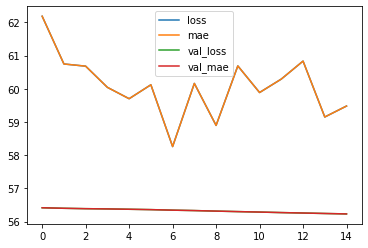

1/1 [==============================] - 0s 260ms/step - loss: 48.9758 - mae: 48.9758
[48.975807189941406, 48.975807189941406]
1/1 [==============================] - 0s 193ms/step
receta 0 kcal_true: 821.5 kcal_pred: 947.16144  precisión: 86.7 %
receta 0 carbohydrate_true: 126.8 carbohydrate_pred: 162.3631  precisión: 78.1 %
receta 0 protein_true: 8.54 protein_pred: 22.812815  precisión: 37.4 %
receta 0 total_fat_true: 27.56 total_fat_pred: 8.681652  precisión: 31.5 %
---------------------------------------------------------------------------
receta 1 kcal_true: 889.5 kcal_pred: 865.53625  precisión: 97.3 %
receta 1 carbohydrate_true: 210.2 carbohydrate_pred: 73.585594  precisión: 35.0 %
receta 1 protein_true: 51.16 protein_pred: 40.465904  precisión: 79.1 %
receta 1 total_fat_true: 5.0 total_fat_pred: 27.83783  precisión: 18.0 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1004.0 kcal_pred: 1127.2783  precisión: 89.1 %
receta 2 carbohyd

100%|██████████| 500/500 [01:50<00:00,  4.53it/s]


Epoch 351/365
13/13 [==============================] - 8s 588ms/step - loss: 138.1058 - mae: 138.1058 - val_loss: 146.1955 - val_mae: 146.1955
Epoch 352/365
13/13 [==============================] - 7s 515ms/step - loss: 139.3961 - mae: 139.3961 - val_loss: 145.0833 - val_mae: 145.0833
Epoch 353/365
13/13 [==============================] - 9s 710ms/step - loss: 136.5913 - mae: 136.5913 - val_loss: 143.9154 - val_mae: 143.9154
Epoch 354/365
13/13 [==============================] - 8s 614ms/step - loss: 138.0037 - mae: 138.0037 - val_loss: 142.7578 - val_mae: 142.7578
Epoch 355/365
13/13 [==============================] - 7s 517ms/step - loss: 136.7047 - mae: 136.7047 - val_loss: 141.6099 - val_mae: 141.6099
Epoch 356/365
13/13 [==============================] - 7s 541ms/step - loss: 137.3271 - mae: 137.3271 - val_loss: 140.4984 - val_mae: 140.4984
Epoch 357/365
13/13 [==============================] - 7s 558ms/step - loss: 134.0537 - mae: 134.0537 - val_loss: 139.4098 - val_mae: 139.4098

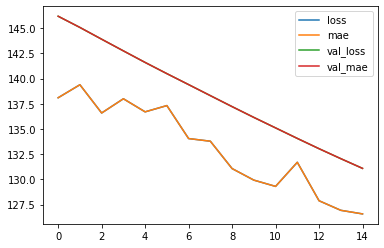

1/1 [==============================] - 0s 237ms/step - loss: 128.3999 - mae: 128.3999
[128.39993286132812, 128.39993286132812]
1/1 [==============================] - 0s 183ms/step
receta 0 kcal_true: 1324.0 kcal_pred: 1012.2237  precisión: 76.5 %
receta 0 carbohydrate_true: 251.0 carbohydrate_pred: 109.57476  precisión: 43.7 %
receta 0 protein_true: 73.7 protein_pred: 40.450996  precisión: 54.9 %
receta 0 total_fat_true: 9.31 total_fat_pred: 27.142784  precisión: 34.3 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1350.0 kcal_pred: 1106.563  precisión: 82.0 %
receta 1 carbohydrate_true: 253.4 carbohydrate_pred: 169.8472  precisión: 67.0 %
receta 1 protein_true: 26.98 protein_pred: 30.79511  precisión: 87.6 %
receta 1 total_fat_true: 26.9 total_fat_pred: 16.288103  precisión: 60.5 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1581.0 kcal_pred: 998.986  precisión: 63.2 %
receta 2 carboh

100%|██████████| 500/500 [01:48<00:00,  4.63it/s]


Epoch 365/379
13/13 [==============================] - 8s 545ms/step - loss: 131.6579 - mae: 131.6579 - val_loss: 144.0438 - val_mae: 144.0438
Epoch 366/379
13/13 [==============================] - 7s 540ms/step - loss: 132.8136 - mae: 132.8136 - val_loss: 142.6303 - val_mae: 142.6303
Epoch 367/379
13/13 [==============================] - 7s 543ms/step - loss: 127.6750 - mae: 127.6750 - val_loss: 141.1499 - val_mae: 141.1499
Epoch 368/379
13/13 [==============================] - 8s 625ms/step - loss: 129.0385 - mae: 129.0385 - val_loss: 139.7198 - val_mae: 139.7198
Epoch 369/379
13/13 [==============================] - 9s 704ms/step - loss: 127.4193 - mae: 127.4193 - val_loss: 138.3516 - val_mae: 138.3516
Epoch 370/379
13/13 [==============================] - 7s 558ms/step - loss: 129.2551 - mae: 129.2551 - val_loss: 137.0576 - val_mae: 137.0576
Epoch 371/379
13/13 [==============================] - 7s 538ms/step - loss: 124.9157 - mae: 124.9157 - val_loss: 135.8193 - val_mae: 135.8193

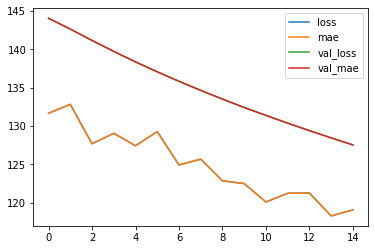

1/1 [==============================] - 0s 276ms/step - loss: 107.9337 - mae: 107.9337
[107.9337158203125, 107.9337158203125]
1/1 [==============================] - 0s 183ms/step
receta 0 kcal_true: 652.0 kcal_pred: 867.91003  precisión: 75.1 %
receta 0 carbohydrate_true: 28.2 carbohydrate_pred: 50.469494  precisión: 55.9 %
receta 0 protein_true: 32.0 protein_pred: 50.042  precisión: 63.9 %
receta 0 total_fat_true: 45.2 total_fat_pred: 32.54108  precisión: 72.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 424.2 kcal_pred: 820.41626  precisión: 51.7 %
receta 1 carbohydrate_true: 46.7 carbohydrate_pred: 90.05702  precisión: 51.8 %
receta 1 protein_true: 33.0 protein_pred: 32.65331  precisión: 98.9 %
receta 1 total_fat_true: 11.62 total_fat_pred: 21.384188  precisión: 54.3 %
---------------------------------------------------------------------------
receta 2 kcal_true: 745.5 kcal_pred: 889.3697  precisión: 83.8 %
receta 2 carbohydrate_tr

100%|██████████| 500/500 [01:41<00:00,  4.95it/s]


Epoch 379/393
13/13 [==============================] - 7s 508ms/step - loss: 60.0894 - mae: 60.0894 - val_loss: 52.3502 - val_mae: 52.3502
Epoch 380/393
13/13 [==============================] - 6s 496ms/step - loss: 58.5886 - mae: 58.5886 - val_loss: 52.3284 - val_mae: 52.3284
Epoch 381/393
13/13 [==============================] - 7s 499ms/step - loss: 63.6065 - mae: 63.6065 - val_loss: 52.2890 - val_mae: 52.2890
Epoch 382/393
13/13 [==============================] - 7s 501ms/step - loss: 59.9503 - mae: 59.9503 - val_loss: 52.2559 - val_mae: 52.2559
Epoch 383/393
13/13 [==============================] - 7s 499ms/step - loss: 60.4728 - mae: 60.4728 - val_loss: 52.2321 - val_mae: 52.2321
Epoch 384/393
13/13 [==============================] - 6s 497ms/step - loss: 58.5640 - mae: 58.5640 - val_loss: 52.2174 - val_mae: 52.2174
Epoch 385/393
13/13 [==============================] - 6s 498ms/step - loss: 61.2607 - mae: 61.2607 - val_loss: 52.2057 - val_mae: 52.2057
Epoch 386/393
13/13 [======

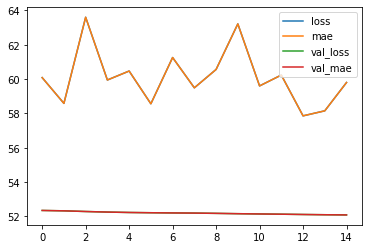

1/1 [==============================] - 0s 275ms/step - loss: 56.3473 - mae: 56.3473
[56.347320556640625, 56.347320556640625]
1/1 [==============================] - 0s 182ms/step
receta 0 kcal_true: 1193.0 kcal_pred: 1031.9948  precisión: 86.5 %
receta 0 carbohydrate_true: 290.5 carbohydrate_pred: 183.92303  precisión: 63.3 %
receta 0 protein_true: 16.22 protein_pred: 23.371323  precisión: 69.4 %
receta 0 total_fat_true: 6.87 total_fat_pred: 7.890039  precisión: 87.1 %
---------------------------------------------------------------------------
receta 1 kcal_true: 992.5 kcal_pred: 1209.0469  precisión: 82.1 %
receta 1 carbohydrate_true: 1.27 carbohydrate_pred: 35.842354  precisión: 3.5 %
receta 1 protein_true: 173.1 protein_pred: 105.008545  precisión: 60.7 %
receta 1 total_fat_true: 33.56 total_fat_pred: 42.266125  precisión: 79.4 %
---------------------------------------------------------------------------
receta 2 kcal_true: 881.5 kcal_pred: 1099.242  precisión: 80.2 %
receta 2 carboh

100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


Epoch 393/407
13/13 [==============================] - 8s 546ms/step - loss: 140.8857 - mae: 140.8857 - val_loss: 146.7229 - val_mae: 146.7229
Epoch 394/407
13/13 [==============================] - 7s 505ms/step - loss: 141.2729 - mae: 141.2729 - val_loss: 145.7336 - val_mae: 145.7336
Epoch 395/407
13/13 [==============================] - 7s 503ms/step - loss: 139.5628 - mae: 139.5628 - val_loss: 144.6507 - val_mae: 144.6507
Epoch 396/407
13/13 [==============================] - 7s 519ms/step - loss: 137.1927 - mae: 137.1927 - val_loss: 143.5588 - val_mae: 143.5588
Epoch 397/407
13/13 [==============================] - 7s 535ms/step - loss: 138.4706 - mae: 138.4706 - val_loss: 142.4721 - val_mae: 142.4721
Epoch 398/407
13/13 [==============================] - 7s 503ms/step - loss: 133.5183 - mae: 133.5183 - val_loss: 141.3981 - val_mae: 141.3981
Epoch 399/407
13/13 [==============================] - 7s 506ms/step - loss: 136.5414 - mae: 136.5414 - val_loss: 140.3450 - val_mae: 140.3450

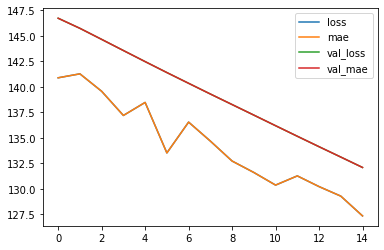

1/1 [==============================] - 0s 479ms/step - loss: 119.6168 - mae: 119.6168
[119.61677551269531, 119.61677551269531]
1/1 [==============================] - 0s 307ms/step
receta 0 kcal_true: 1253.0 kcal_pred: 1259.5255  precisión: 99.5 %
receta 0 carbohydrate_true: 58.8 carbohydrate_pred: 81.33871  precisión: 72.3 %
receta 0 protein_true: 64.06 protein_pred: 76.42003  precisión: 83.8 %
receta 0 total_fat_true: 84.1 total_fat_pred: 42.857452  precisión: 50.9 %
---------------------------------------------------------------------------
receta 1 kcal_true: 1404.0 kcal_pred: 1211.9061  precisión: 86.3 %
receta 1 carbohydrate_true: 122.2 carbohydrate_pred: 126.8201  precisión: 96.3 %
receta 1 protein_true: 34.38 protein_pred: 49.06371  precisión: 70.1 %
receta 1 total_fat_true: 86.0 total_fat_pred: 33.362473  precisión: 38.8 %
---------------------------------------------------------------------------
receta 2 kcal_true: 1586.0 kcal_pred: 1080.4476  precisión: 68.1 %
receta 2 carbo

<AxesSubplot:xlabel='iteracion'>

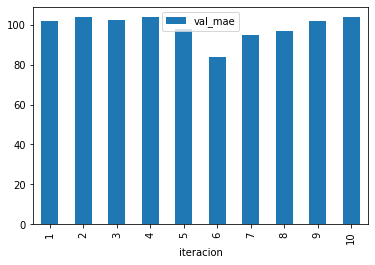

In [7]:
recomendador128.NUM_RECETAS = 500
recomendador128.EMB_SIZE = 128
BATCHSIZE = 32
ITER = 10
INITIAL_EPOCH = 0
EPOCHS = recomendador128.NUM_RECETAS // BATCHSIZE
#EPOCHS = 15
LR = 1e-4

Rangos_kcal = [
                (300, 800),
                (801, 1200),
                (1201, 1700)           
                #(500, 1500)              
              ]

Its = []
Valmaes = []
Histories = []
val_mae = 1000
MAX_VAL_MAE = 51
iteracion = 0

#for iteracion in range(ITER):
while val_mae > MAX_VAL_MAE and iteracion<ITER:
  MINU = 1 
  MAXU = 10  
  #INITIAL_EPOCH = 0

  tmp_val_mae = 0
  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('VAL_MAE:', val_mae)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    try:
      modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                                          learning_rate=LR,
                                                          version=version, 
                                                          initial_epoch = INITIAL_EPOCH,                             
                                                          epochs=INITIAL_EPOCH + EPOCHS, 
                                                          batch_size=BATCHSIZE,
                                                          kernels=128,                                             
                                                          min_ingredientes=5, max_ingredientes=11,                                  
                                                          min_unidades=MINU, max_unidades=MAXU,  
                                                          min_kcal=MINK, max_kcal= MAXK,                             
                                                          save=True, verbose=True)
      INITIAL_EPOCH = history.epoch[-1]      
      tmp_val_mae += float(history.history['val_mae'][-1])           
      Histories.append(history)

    except:
      print('Falló al entrenar en interación', iteracion)
      pass
  
  val_mae = tmp_val_mae / len(Rangos_kcal)
  print('VAL_MAE Promedio:', val_mae)
  iteracion += 1
  Its.append(iteracion)
  Valmaes.append(val_mae)


dfVM = pd.DataFrame({'iteracion':Its, 'val_mae':Valmaes}, columns=['iteracion', 'val_mae'])
dfVM.plot(kind='bar', x='iteracion', y='val_mae')

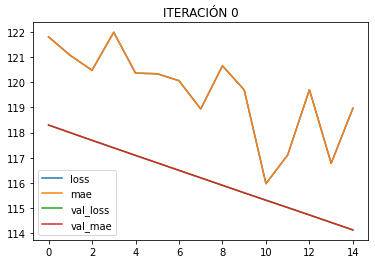

LOSS: 118.96753692626953  -- MAE: 118.96753692626953  -- VAL_LOSS: 114.13519287109375  -- VAL_MAE: 114.13519287109375
----------------------------------------------------------


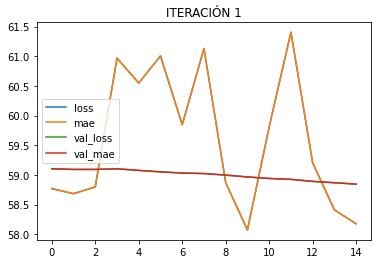

LOSS: 58.17564392089844  -- MAE: 58.17564392089844  -- VAL_LOSS: 58.845069885253906  -- VAL_MAE: 58.845069885253906
----------------------------------------------------------


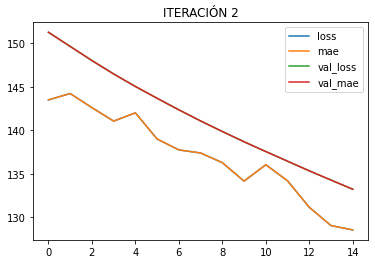

LOSS: 128.5317840576172  -- MAE: 128.5317840576172  -- VAL_LOSS: 133.21200561523438  -- VAL_MAE: 133.21200561523438
----------------------------------------------------------


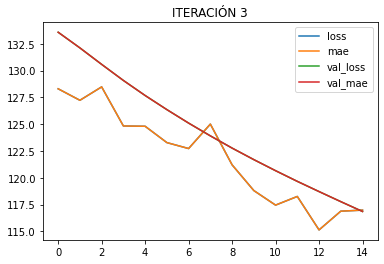

LOSS: 116.97941589355469  -- MAE: 116.97941589355469  -- VAL_LOSS: 116.85184478759766  -- VAL_MAE: 116.85184478759766
----------------------------------------------------------


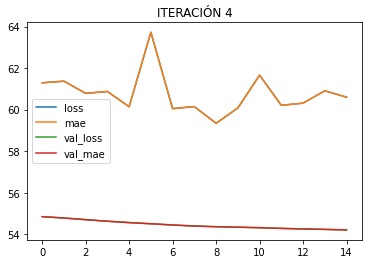

LOSS: 60.60002136230469  -- MAE: 60.60002136230469  -- VAL_LOSS: 54.20509719848633  -- VAL_MAE: 54.20509719848633
----------------------------------------------------------


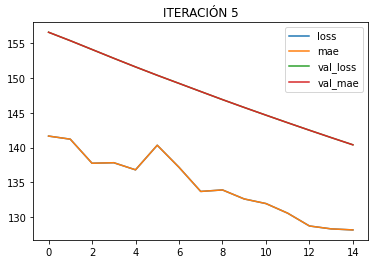

LOSS: 128.1881103515625  -- MAE: 128.1881103515625  -- VAL_LOSS: 140.40785217285156  -- VAL_MAE: 140.40785217285156
----------------------------------------------------------


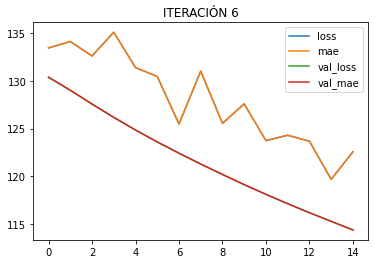

LOSS: 122.5694351196289  -- MAE: 122.5694351196289  -- VAL_LOSS: 114.381591796875  -- VAL_MAE: 114.381591796875
----------------------------------------------------------


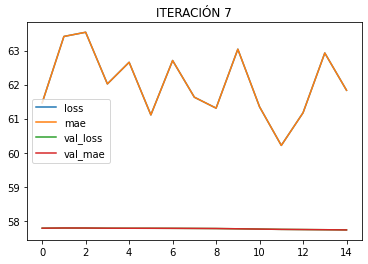

LOSS: 61.83309555053711  -- MAE: 61.83309555053711  -- VAL_LOSS: 57.73514938354492  -- VAL_MAE: 57.73514938354492
----------------------------------------------------------


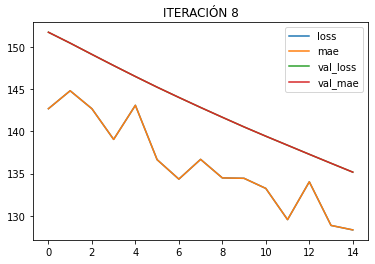

LOSS: 128.30770874023438  -- MAE: 128.30770874023438  -- VAL_LOSS: 135.17095947265625  -- VAL_MAE: 135.17095947265625
----------------------------------------------------------


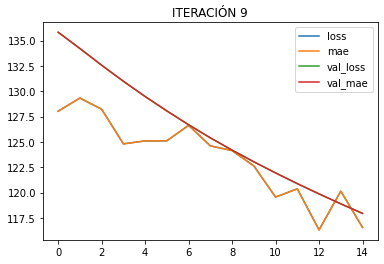

LOSS: 116.56294250488281  -- MAE: 116.56294250488281  -- VAL_LOSS: 117.9452896118164  -- VAL_MAE: 117.9452896118164
----------------------------------------------------------


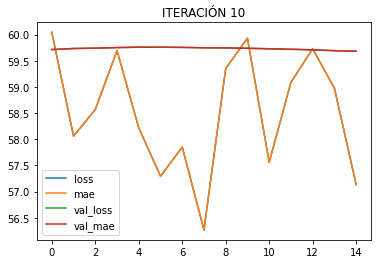

LOSS: 57.13261795043945  -- MAE: 57.13261795043945  -- VAL_LOSS: 59.68223190307617  -- VAL_MAE: 59.68223190307617
----------------------------------------------------------


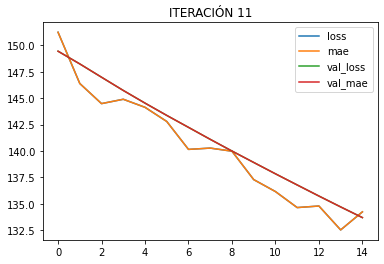

LOSS: 134.22738647460938  -- MAE: 134.22738647460938  -- VAL_LOSS: 133.6837921142578  -- VAL_MAE: 133.6837921142578
----------------------------------------------------------


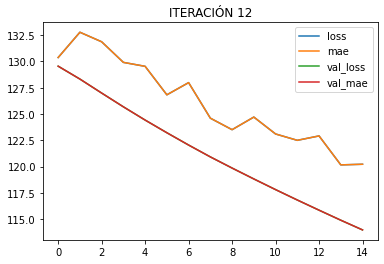

LOSS: 120.22505187988281  -- MAE: 120.22505187988281  -- VAL_LOSS: 113.97920227050781  -- VAL_MAE: 113.97920227050781
----------------------------------------------------------


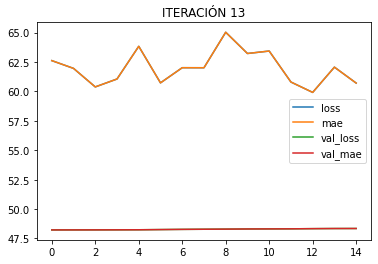

LOSS: 60.71324157714844  -- MAE: 60.71324157714844  -- VAL_LOSS: 48.34723663330078  -- VAL_MAE: 48.34723663330078
----------------------------------------------------------


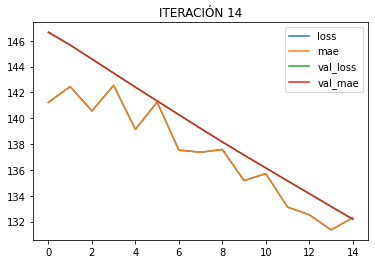

LOSS: 132.29864501953125  -- MAE: 132.29864501953125  -- VAL_LOSS: 132.18299865722656  -- VAL_MAE: 132.18299865722656
----------------------------------------------------------


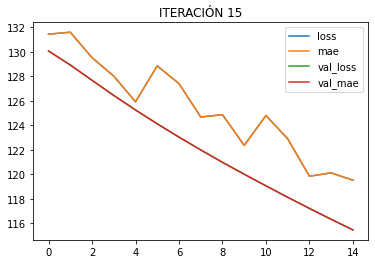

LOSS: 119.51876831054688  -- MAE: 119.51876831054688  -- VAL_LOSS: 115.45967102050781  -- VAL_MAE: 115.45967102050781
----------------------------------------------------------


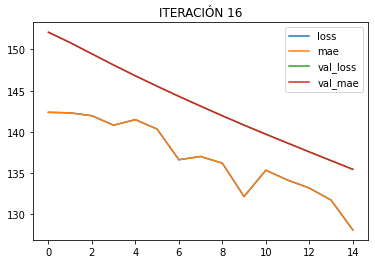

LOSS: 128.13134765625  -- MAE: 128.13134765625  -- VAL_LOSS: 135.47891235351562  -- VAL_MAE: 135.47891235351562
----------------------------------------------------------


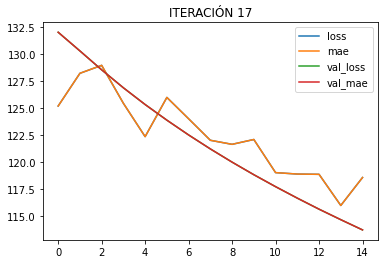

LOSS: 118.55628204345703  -- MAE: 118.55628204345703  -- VAL_LOSS: 113.69908142089844  -- VAL_MAE: 113.69908142089844
----------------------------------------------------------


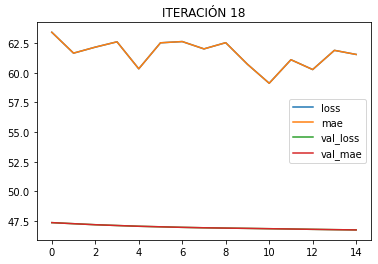

LOSS: 61.542545318603516  -- MAE: 61.542545318603516  -- VAL_LOSS: 46.76218795776367  -- VAL_MAE: 46.76218795776367
----------------------------------------------------------


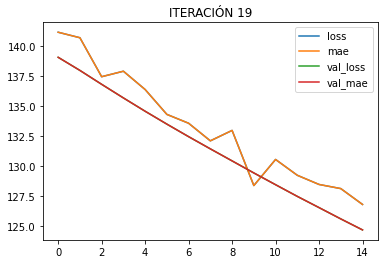

LOSS: 126.79737091064453  -- MAE: 126.79737091064453  -- VAL_LOSS: 124.67268371582031  -- VAL_MAE: 124.67268371582031
----------------------------------------------------------


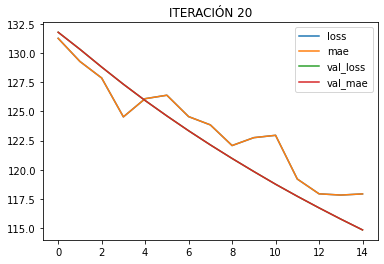

LOSS: 117.9266128540039  -- MAE: 117.9266128540039  -- VAL_LOSS: 114.84017181396484  -- VAL_MAE: 114.84017181396484
----------------------------------------------------------


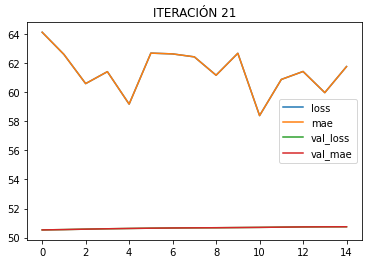

LOSS: 61.76673889160156  -- MAE: 61.76673889160156  -- VAL_LOSS: 50.74834060668945  -- VAL_MAE: 50.74834060668945
----------------------------------------------------------


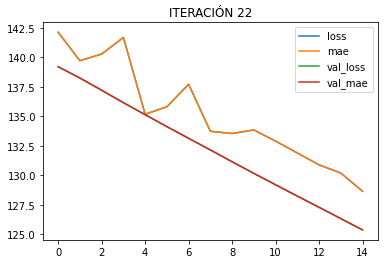

LOSS: 128.64242553710938  -- MAE: 128.64242553710938  -- VAL_LOSS: 125.36043548583984  -- VAL_MAE: 125.36043548583984
----------------------------------------------------------


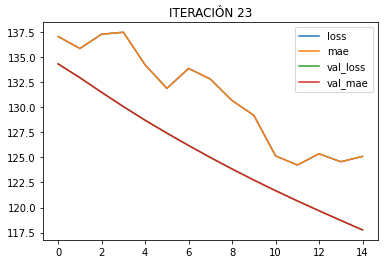

LOSS: 125.09021759033203  -- MAE: 125.09021759033203  -- VAL_LOSS: 117.7711181640625  -- VAL_MAE: 117.7711181640625
----------------------------------------------------------


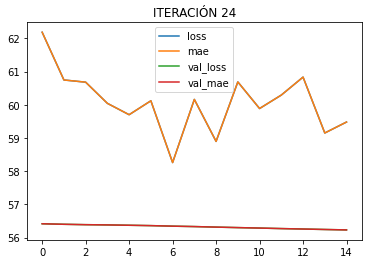

LOSS: 59.482303619384766  -- MAE: 59.482303619384766  -- VAL_LOSS: 56.23145294189453  -- VAL_MAE: 56.23145294189453
----------------------------------------------------------


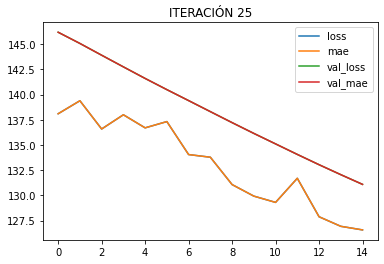

LOSS: 126.57377624511719  -- MAE: 126.57377624511719  -- VAL_LOSS: 131.09396362304688  -- VAL_MAE: 131.09396362304688
----------------------------------------------------------


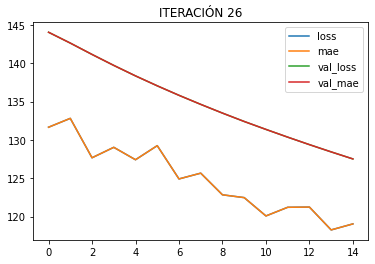

LOSS: 119.05366516113281  -- MAE: 119.05366516113281  -- VAL_LOSS: 127.52311706542969  -- VAL_MAE: 127.52311706542969
----------------------------------------------------------


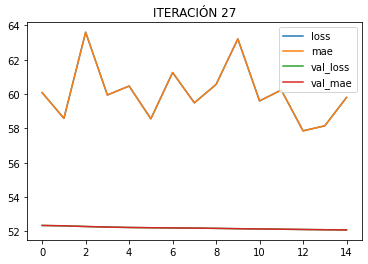

LOSS: 59.80522918701172  -- MAE: 59.80522918701172  -- VAL_LOSS: 52.090171813964844  -- VAL_MAE: 52.090171813964844
----------------------------------------------------------


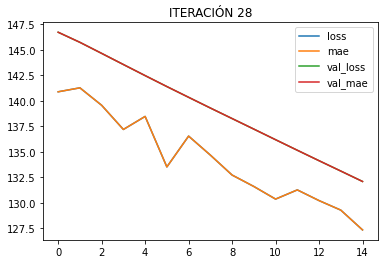

LOSS: 127.34486389160156  -- MAE: 127.34486389160156  -- VAL_LOSS: 132.09417724609375  -- VAL_MAE: 132.09417724609375
----------------------------------------------------------


In [8]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Fine tunning nutrición

Cargado dataset de entrenamiento: datasets/recipes_con_info_nutricional.csv
1090 recetas encontradas.
Calculando vector de características de 1090 recetas...


100%|██████████| 1090/1090 [04:01<00:00,  4.51it/s]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
CapaEntrada False
RESHAPING False
batch_normalization False
CONV_1 False
POOLING_1 False
CONV_2 False
POOLING_2 False
CONV_3 False
POOLING_3 False
dropout_1900 False
flatten False
dense True
dense_1 True
dense_2 True
dropout_1901 True
CapaSalida True
Epoch 1/120
35/35 [==============================] - 5s 127ms/step - loss: 135.0073 - mae: 135.0073 - val_loss: 141.8814 - val_mae: 141.8814
Epoch 2/120
35/35 [==============================] - 4s 113ms/step - loss: 134.1732 - mae: 134.1732 - val_loss: 141.6917 - val_mae: 141.6917
Epoch 3/120
35/35 [==============================] - 4s 116ms/step - loss: 132.1603 - mae: 132.1603 - val_loss: 141.5088 - val_mae: 141.5088
Epoch 4/120
35/35 [==============================] - 4s 120ms/step - loss: 132.2

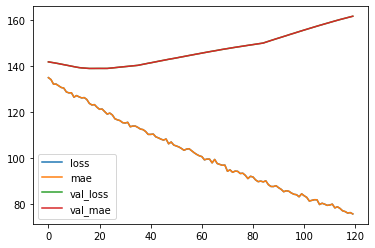

1/1 [==============================] - 0s 229ms/step - loss: 128.9730 - mae: 128.9730
[128.9730224609375, 128.9730224609375]
1/1 [==============================] - 0s 156ms/step
receta 0 kcal_true: 324.0 kcal_pred: 418.6048  precisión: 77.4 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 26.436655  precisión: 34.8 %
receta 0 protein_true: 8.0 protein_pred: 23.525307  precisión: 34.0 %
receta 0 total_fat_true: 0.0 total_fat_pred: 10.911732  precisión: 0.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 359.6385  precisión: 82.5 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 0.0  precisión: 0.0 %
receta 1 protein_true: 8.0 protein_pred: 38.407036  precisión: 20.8 %
receta 1 total_fat_true: 4.0 total_fat_pred: 12.3539505  precisión: 32.4 %
---------------------------------------------------------------------------
receta 2 kcal_true: 846.0 kcal_pred: 393.72415  precisión: 46.5 %
receta 2 carbohydrate_true: 72.

In [9]:
modelo128_ft, history_ft = recomendador128.FineTuneModeloNut(df_nutricionales='nutrcion_mejorado.csv',
                                                            df_training='recipes_con_info_nutricional.csv',
                                                            df_test='recetas_test.csv', df_val='recetas_val.csv',
                                                            learning_rate=1e-6,
                                                            batch_size=32,
                                                            epochs = 120,
                                                            verbose=True, save=True)

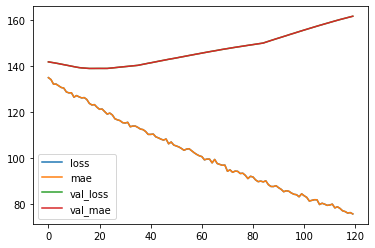

LOSS: 127.34486389160156  -- MAE: 127.34486389160156  -- VAL_LOSS: 132.09417724609375  -- VAL_MAE: 132.09417724609375
----------------------------------------------------------


In [10]:
pd.DataFrame(history_ft.history).plot()
plt.show()
print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
        ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
print('----------------------------------------------------------')

## Entrenar precios

In [7]:
precios = recomendador128.generar_dataset_entrenamiento_precios(min_ingredientes=5, max_ingredientes=11,
                                                      min_unidades=1, max_unidades=10,
                                                      min_precio = 50, max_precio=150,
                                                      numero_recetas=1000
                                                      )

df = pd.DataFrame(precios, columns=['ingredientes', 'precio'])
df['precio'].describe()

Generando 1000  recetas aleatorias...



count      1000
unique      943
top       51.22
freq          3
Name: precio, dtype: object


ITERACIÓN: 1
Rango de precios: $ 50  y  $ 150
Entrenando desde epoch 0
------------------------------------------

Generando 1000  recetas aleatorias...

Calculando vector de características de 1000 recetas...


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


Epoch 1/31
25/25 [==============================] - 18s 695ms/step - loss: 63.8193 - mae: 63.8193 - val_loss: 42.5639 - val_mae: 42.5639
Epoch 2/31
25/25 [==============================] - 18s 732ms/step - loss: 42.5196 - mae: 42.5196 - val_loss: 28.2408 - val_mae: 28.2408
Epoch 3/31
25/25 [==============================] - 18s 709ms/step - loss: 41.1141 - mae: 41.1141 - val_loss: 29.4484 - val_mae: 29.4484
Epoch 4/31
25/25 [==============================] - 18s 721ms/step - loss: 38.8740 - mae: 38.8740 - val_loss: 28.5970 - val_mae: 28.5970
Epoch 5/31
25/25 [==============================] - 18s 705ms/step - loss: 37.3440 - mae: 37.3440 - val_loss: 27.6655 - val_mae: 27.6655
Epoch 6/31
25/25 [==============================] - 18s 705ms/step - loss: 37.3780 - mae: 37.3780 - val_loss: 26.5970 - val_mae: 26.5970
Epoch 7/31
25/25 [==============================] - 18s 709ms/step - loss: 37.6931 - mae: 37.6931 - val_loss: 26.3420 - val_mae: 26.3420
Epoch 8/31
25/25 [=======================

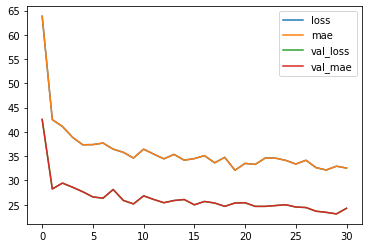

7/7 [==============================] - 1s 76ms/step - loss: 23.7435 - mae: 23.7435
[23.74353790283203, 23.74353790283203]
7/7 [==============================] - 1s 94ms/step
receta 0 precio_prom_por_gramo_true: 88.3 precio_prom_por_gramo_pred: 103.347855  precisión: 85.5 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 143.0 precio_prom_por_gramo_pred: 72.127335  precisión: 50.4 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 78.94 precio_prom_por_gramo_pred: 67.12597  precisión: 85.0 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 56.6 precio_prom_por_gramo_pred: 70.93377  precisión: 79.8 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 101.56 precio_prom_por_gramo_pred: 74.66064  precisión: 73.5 %
-------------------------

100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]


Epoch 31/61
25/25 [==============================] - 19s 765ms/step - loss: 93.8175 - mae: 93.8175 - val_loss: 46.4626 - val_mae: 46.4626
Epoch 32/61
25/25 [==============================] - 18s 728ms/step - loss: 66.3444 - mae: 66.3444 - val_loss: 45.0051 - val_mae: 45.0051
Epoch 33/61
25/25 [==============================] - 18s 711ms/step - loss: 68.2728 - mae: 68.2728 - val_loss: 47.9665 - val_mae: 47.9665
Epoch 34/61
25/25 [==============================] - 19s 762ms/step - loss: 63.6869 - mae: 63.6869 - val_loss: 48.6250 - val_mae: 48.6250
Epoch 35/61
25/25 [==============================] - 20s 795ms/step - loss: 64.9247 - mae: 64.9247 - val_loss: 44.0031 - val_mae: 44.0031
Epoch 36/61
25/25 [==============================] - 20s 783ms/step - loss: 63.5299 - mae: 63.5299 - val_loss: 47.2020 - val_mae: 47.2020
Epoch 37/61
25/25 [==============================] - 19s 753ms/step - loss: 64.1568 - mae: 64.1568 - val_loss: 45.9081 - val_mae: 45.9081
Epoch 38/61
25/25 [===============

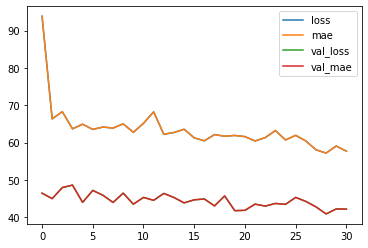

7/7 [==============================] - 1s 99ms/step - loss: 41.4025 - mae: 41.4025
[41.40250015258789, 41.40250015258789]
7/7 [==============================] - 1s 89ms/step
receta 0 precio_prom_por_gramo_true: 241.2 precio_prom_por_gramo_pred: 221.03624  precisión: 91.6 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 187.9 precio_prom_por_gramo_pred: 198.93025  precisión: 94.4 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 273.8 precio_prom_por_gramo_pred: 252.12828  precisión: 92.1 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 250.0 precio_prom_por_gramo_pred: 183.2005  precisión: 73.3 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 233.1 precio_prom_por_gramo_pred: 198.62904  precisión: 85.2 %
-----------------------

100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch 61/91
25/25 [==============================] - 17s 681ms/step - loss: 136.9032 - mae: 136.9032 - val_loss: 53.4379 - val_mae: 53.4379
Epoch 62/91
25/25 [==============================] - 18s 724ms/step - loss: 100.7190 - mae: 100.7190 - val_loss: 52.1845 - val_mae: 52.1845
Epoch 63/91
25/25 [==============================] - 17s 694ms/step - loss: 103.6383 - mae: 103.6383 - val_loss: 53.6399 - val_mae: 53.6399
Epoch 64/91
25/25 [==============================] - 17s 702ms/step - loss: 96.9952 - mae: 96.9952 - val_loss: 50.6161 - val_mae: 50.6161
Epoch 65/91
25/25 [==============================] - 17s 698ms/step - loss: 99.4793 - mae: 99.4793 - val_loss: 53.9292 - val_mae: 53.9292
Epoch 66/91
25/25 [==============================] - 18s 706ms/step - loss: 99.0794 - mae: 99.0794 - val_loss: 51.9185 - val_mae: 51.9185
Epoch 67/91
25/25 [==============================] - 18s 708ms/step - loss: 97.7238 - mae: 97.7238 - val_loss: 52.9336 - val_mae: 52.9336
Epoch 68/91
25/25 [=========

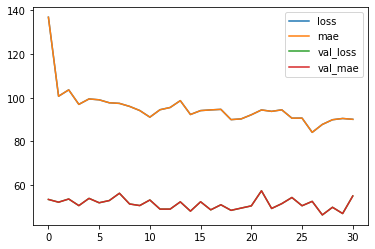

7/7 [==============================] - 1s 101ms/step - loss: 56.1465 - mae: 56.1465
[56.14653396606445, 56.14653396606445]
7/7 [==============================] - 1s 101ms/step
receta 0 precio_prom_por_gramo_true: 352.2 precio_prom_por_gramo_pred: 376.23993  precisión: 93.6 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 378.5 precio_prom_por_gramo_pred: 370.17108  precisión: 97.8 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 470.2 precio_prom_por_gramo_pred: 412.23712  precisión: 87.7 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 373.5 precio_prom_por_gramo_pred: 408.7981  precisión: 91.4 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 385.0 precio_prom_por_gramo_pred: 426.71268  precisión: 90.2 %
---------------------

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


Epoch 91/121
25/25 [==============================] - 17s 672ms/step - loss: 157.3358 - mae: 157.3358 - val_loss: 79.1530 - val_mae: 79.1530
Epoch 92/121
25/25 [==============================] - 17s 705ms/step - loss: 127.1042 - mae: 127.1042 - val_loss: 63.1700 - val_mae: 63.1700
Epoch 93/121
25/25 [==============================] - 18s 709ms/step - loss: 127.2956 - mae: 127.2956 - val_loss: 60.1290 - val_mae: 60.1290
Epoch 94/121
25/25 [==============================] - 18s 710ms/step - loss: 133.2535 - mae: 133.2535 - val_loss: 73.4019 - val_mae: 73.4019
Epoch 95/121
25/25 [==============================] - 18s 713ms/step - loss: 132.6355 - mae: 132.6355 - val_loss: 72.2532 - val_mae: 72.2532
Epoch 96/121
25/25 [==============================] - 17s 704ms/step - loss: 131.3210 - mae: 131.3210 - val_loss: 81.5093 - val_mae: 81.5093
Epoch 97/121
25/25 [==============================] - 18s 727ms/step - loss: 133.4693 - mae: 133.4693 - val_loss: 60.2505 - val_mae: 60.2505
Epoch 98/121


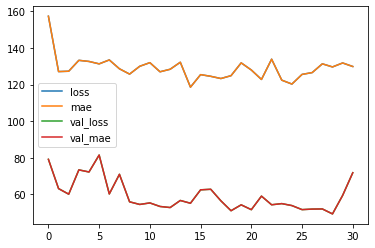

7/7 [==============================] - 1s 113ms/step - loss: 71.6809 - mae: 71.6809
[71.68087768554688, 71.68087768554688]
7/7 [==============================] - 1s 105ms/step
receta 0 precio_prom_por_gramo_true: 681.0 precio_prom_por_gramo_pred: 593.80634  precisión: 87.2 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 644.5 precio_prom_por_gramo_pred: 585.3091  precisión: 90.8 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 642.0 precio_prom_por_gramo_pred: 526.7484  precisión: 82.0 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 681.0 precio_prom_por_gramo_pred: 561.1031  precisión: 82.4 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 615.0 precio_prom_por_gramo_pred: 544.0902  precisión: 88.5 %
------------------------

100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


Epoch 121/151
25/25 [==============================] - 17s 665ms/step - loss: 183.7821 - mae: 183.7821 - val_loss: 90.2284 - val_mae: 90.2284
Epoch 122/151
25/25 [==============================] - 17s 699ms/step - loss: 178.5554 - mae: 178.5554 - val_loss: 78.6673 - val_mae: 78.6673
Epoch 123/151
25/25 [==============================] - 18s 706ms/step - loss: 171.1893 - mae: 171.1893 - val_loss: 92.3962 - val_mae: 92.3962
Epoch 124/151
25/25 [==============================] - 18s 705ms/step - loss: 175.4280 - mae: 175.4280 - val_loss: 92.7839 - val_mae: 92.7839
Epoch 125/151
25/25 [==============================] - 17s 703ms/step - loss: 164.3152 - mae: 164.3152 - val_loss: 71.8904 - val_mae: 71.8904
Epoch 126/151
25/25 [==============================] - 17s 673ms/step - loss: 161.8110 - mae: 161.8110 - val_loss: 69.9960 - val_mae: 69.9960
Epoch 127/151
25/25 [==============================] - 17s 699ms/step - loss: 165.8031 - mae: 165.8031 - val_loss: 71.1270 - val_mae: 71.1270
Epoch 

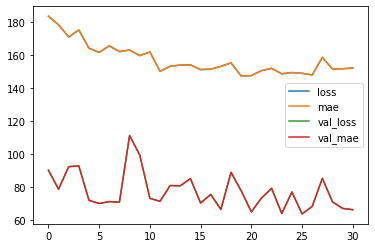

7/7 [==============================] - 1s 103ms/step - loss: 65.5690 - mae: 65.5690
[65.56903076171875, 65.56903076171875]
7/7 [==============================] - 1s 90ms/step
receta 0 precio_prom_por_gramo_true: 816.0 precio_prom_por_gramo_pred: 808.30145  precisión: 99.1 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 999.0 precio_prom_por_gramo_pred: 768.10126  precisión: 76.9 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 855.5 precio_prom_por_gramo_pred: 849.3144  precisión: 99.3 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 787.5 precio_prom_por_gramo_pred: 788.471  precisión: 99.9 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 804.5 precio_prom_por_gramo_pred: 827.4252  precisión: 97.2 %
-------------------------

In [11]:
recomendador128.NUM_RECETAS = 1000
recomendador128.EMB_SIZE = 128
BATCHSIZE = 32
ITER = 1
INITIAL_EPOCH = 0
EPOCHS = recomendador128.NUM_RECETAS // BATCHSIZE
MINU = 1 
MAXU = 10  

Rangos_precios = [(50, 150), (151, 350), (351, 550), (551, 750), (751, 1001)]

Histories_precios = []
for iteracion in range(ITER):
    for ip in range(len(Rangos_precios)):
        MINP, MAXP = Rangos_precios[ip]
        print('\nITERACIÓN:', iteracion+1)
        print('Rango de precios: $', MINP, ' y  $', MAXP)
        print('Entrenando desde epoch', INITIAL_EPOCH)
        print('------------------------------------------\n')
        modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                        df_precios='lista_precios_profeco_2022.csv',                                   
                                        learning_rate=1e-4,
                                        version=version, 
                                        initial_epoch = INITIAL_EPOCH,                             
                                        epochs=INITIAL_EPOCH + EPOCHS, 
                                        min_ingredientes=5, max_ingredientes=11,                                  
                                        min_unidades=MINU, max_unidades=MAXU,
                                        min_precio=MINP, max_precio=MAXP,
                                        batch_size=BATCHSIZE,
                                        kernels=128,                                                                         
                                        save=True, verbose=True)
        INITIAL_EPOCH = history_precios.epoch[-1]

        Histories_precios.append(history_precios)

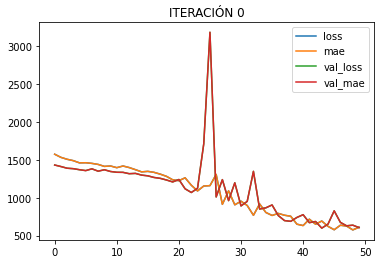

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


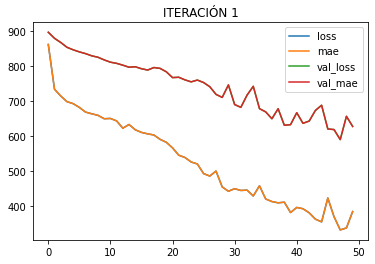

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')